In [2]:
!head -n 1 KP_class_1.jsonl
!cat gazeta_train.jsonl | wc -l
!cat gazeta_val.jsonl | wc -l
!cat gazeta_test.jsonl | wc -l
!cat KP_class_1.jsonl | wc -l

{"title": "В Воронеже поймали на присвоении денег руководителя аграрного университета", "text": "Алексей Попов.Сотрудники Следственного комитета во взаимодействии с сотрудниками ФСБ «раскручивают» очередной скандал, связанный с присвоением денег, положенных в качестве премий рядовым сотрудникам. На этот раз попался и.о. ректора Воронежского аграрного университета Алексей Попов.По данным следствия, в марте 2021 года врио ректора потребовал от подчиненных передать ему часть денег, полученных в виде премий. 10 марта Попова задержали с поличным при получении 880 тысяч рублей. Возбуждено уголовное дело по ч.3 ст. 30, ч.3 ст. 160 УК РФ «Покушение на присвоение денежных средств в крупном размере, совершенное с использованием служебного положения». Силовики провели обыск в служебном кабинете Попова. Его поместили в изолятор временного содержания.- У врио ректора изъяли полученные деньги, он признал свою вину. В ближайшее время будет решен вопрос об избрании меры пресечения, - сообщил и.о. руко

In [1]:
import json
import random

def read_gazeta_records(file_name, shuffle=False, sort_by_date=False):
    #assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

train_records = read_gazeta_records("gazeta_train.jsonl")
val_records = read_gazeta_records("gazeta_val.jsonl")
test_records = read_gazeta_records("gazeta_test.jsonl")

In [2]:
import razdel
import pymorphy2
from collections import Counter

morph = pymorphy2.MorphAnalyzer()

def calc_text_words(text, lower=True):
    words = [word.text for word in razdel.tokenize(text)]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    if lower:
        words = [w.lower() for w in words]
        lemmas = [w.lower() for w in lemmas]
    unique_words = set(words)
    unique_lemmas = set(lemmas)
    return words, lemmas, unique_words, unique_lemmas

def calc_stats(records): 
    text_words_counts = []
    text_unique_words_counts = []
    text_unique_lemmas_counts = []
    text_words_vocabulary = Counter()
    text_lemmas_vocabulary = Counter()

    summary_words_counts = []
    summary_unique_words_counts = []
    summary_unique_lemmas_counts = []
    summary_words_vocabulary = Counter()
    summary_lemmas_vocabulary = Counter()

    unique_words_intersection_parts = []
    unique_lemmas_intersection_parts = []

    bigrams_intersection_counts = []
    trigrams_intersection_counts = []
    bigrams_intersection_parts = []
    trigrams_intersection_parts = []

    bilemmas_intersection_counts = []
    bilemmas_intersection_parts = []

    unique_words_intersection_counts = []
    unique_lemmas_intersection_counts = []

    text_sentences_counts = []
    summary_sentences_counts = []

    for i, record in enumerate(records):
        text = record["text"]
        summary = record["summary"]
        title = record["title"]
        text_sentences_counts.append(len(list(razdel.sentenize(text))))
        summary_sentences_counts.append(len(list(razdel.sentenize(summary))))
        text_words, text_lemmas, text_unique_words, text_unique_lemmas = calc_text_words(text)
        summary_words, summary_lemmas, summary_unique_words, summary_unique_lemmas = calc_text_words(summary)
        text_words_counts.append(len(text_words))
        text_unique_words_counts.append(len(text_unique_words))
        text_unique_lemmas_counts.append(len(text_unique_lemmas))
        text_words_vocabulary.update(text_words)
        text_lemmas_vocabulary.update(text_lemmas)
        summary_words_counts.append(len(summary_words))
        summary_unique_words_counts.append(len(summary_unique_words))
        summary_unique_lemmas_counts.append(len(summary_unique_lemmas))
        summary_words_vocabulary.update(summary_words)
        summary_lemmas_vocabulary.update(summary_lemmas)
        unique_words_intersection_counts.append(len(summary_unique_words.intersection(text_unique_words)))
        unique_lemmas_intersection_counts.append(len(summary_unique_lemmas.intersection(text_unique_lemmas)))
        unique_words_intersection_parts.append(len(summary_unique_words.intersection(text_unique_words)) / len(summary_unique_words))
        unique_lemmas_intersection_parts.append(len(summary_unique_lemmas.intersection(text_unique_lemmas)) / len(summary_unique_lemmas))

        def get_ngrams(words, n):
            return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
        text_bigrams = set(get_ngrams(text_words, 2))
        text_bilemmas = set(get_ngrams(text_lemmas, 2))
        text_trigrams = set(get_ngrams(text_words, 3))
        summary_bigrams = set(get_ngrams(summary_words, 2))
        summary_bilemmas = set(get_ngrams(summary_lemmas, 2))
        summary_trigrams = set(get_ngrams(summary_words, 3))
        bigrams_intersection = text_bigrams.intersection(summary_bigrams)
        bilemmas_intersection = text_bilemmas.intersection(summary_bilemmas)
        trigrams_intersection = text_trigrams.intersection(summary_trigrams)
        bigrams_intersection_counts.append(len(bigrams_intersection))
        bilemmas_intersection_counts.append(len(bilemmas_intersection))
        trigrams_intersection_counts.append(len(trigrams_intersection))
        bigrams_intersection_parts.append(len(bigrams_intersection)/len(summary_bigrams))
        bilemmas_intersection_parts.append(len(bilemmas_intersection) / len(summary_bilemmas))
        trigrams_intersection_parts.append(len(trigrams_intersection)/len(summary_trigrams))

    def avg(collection):
        return sum(collection) / len(collection)
    return {
        "text_max_words": max(text_words_counts),
        "text_min_words": min(text_words_counts),
        "text_avg_words": avg(text_words_counts),
        "text_avg_unique_words": avg(text_unique_words_counts),
        "text_avg_unique_lemmas": avg(text_unique_lemmas_counts),
        "text_avg_sentences": avg(text_sentences_counts),
        "summary_avg_sentences": avg(summary_sentences_counts),
        "summary_max_words": max(summary_words_counts),
        "summary_min_words": min(summary_words_counts),
        "summary_avg_words": avg(summary_words_counts),
        "summary_avg_unique_words": avg(summary_unique_words_counts),
        "summary_avg_unique_lemmas": avg(summary_unique_lemmas_counts),
        "avg_common_unique_words": avg(unique_words_intersection_counts),
        "avg_common_unique_lemmas": avg(unique_lemmas_intersection_counts),
        "text_words_vocabulary_size:": len(text_words_vocabulary),
        "text_lemmas_vocabulary_size:": len(text_lemmas_vocabulary),
        "summary_words_vocabulary_size:": len(summary_words_vocabulary),
        "summary_lemmas_vocabulary_size:": len(summary_lemmas_vocabulary),
        "common_vocabulary_words": len(set(text_words_vocabulary.keys()).intersection(set(summary_words_vocabulary.keys()))),
        "common_vocabulary_lemmas": len(set(text_lemmas_vocabulary.keys()).intersection(set(summary_lemmas_vocabulary.keys()))),
        "text_words_counts": text_words_counts,
        "summary_words_counts": summary_words_counts,
        "bigrams_intersection_parts": bigrams_intersection_parts,
        "avg_bigram_intersection": avg(bigrams_intersection_counts),
        "avg_trigram_intersection": avg(trigrams_intersection_counts),
        "avg_bigram_intersection_part": avg(bigrams_intersection_parts),
        "avg_trigram_intersection_part": avg(trigrams_intersection_parts),
        "avg_words_intersection_part": avg(unique_words_intersection_parts),
        "avg_lemmas_intersection_part": avg(unique_lemmas_intersection_parts),
        "avg_bilemmas_intersection_part": avg(bilemmas_intersection_parts)
    }

def print_stats(stats):
    print("Text stats:")
    print("\tMax words: ", stats["text_max_words"])
    print("\tMin words: ", stats["text_min_words"])
    print("\tAvg words: ", stats["text_avg_words"])
    print("\tAvg sentences", stats["text_avg_sentences"])
    print("\tAvg unique words: ", stats["text_avg_unique_words"])
    print("\tAvg unique lemmas: ", stats["text_avg_unique_lemmas"])
    print("Summary stats:")
    print("\tMax words: ", stats["summary_max_words"])
    print("\tMin words: ", stats["summary_min_words"])
    print("\tAvg words: ", stats["summary_avg_words"])
    print("\tAvg sentences", stats["summary_avg_sentences"])
    print("\tAvg unique words: ", stats["summary_avg_unique_words"])
    print("\tAvg unique lemmas: ", stats["summary_avg_unique_lemmas"])
    print("Intersection stats:")
    print("\tAvg common unique words: ", stats["avg_common_unique_words"])
    print("\tAvg common unique lemmas: ", stats["avg_common_unique_lemmas"])
    print("\tAvg common words: ", "{:.2f}%".format(stats["avg_words_intersection_part"] * 100))
    print("\tAvg common lemmas: ", "{:.2f}%".format(stats["avg_lemmas_intersection_part"] * 100))
    print("\tAvg common bigrams: ", "{:.2f}%".format(stats["avg_bigram_intersection_part"] * 100))
    print("\tAvg common trigrams: ", "{:.2f}%".format(stats["avg_trigram_intersection_part"] * 100))

In [ ]:

print("VAL DATASET")
val_stats = calc_stats(val_records)
print_stats(val_stats)
print("TEST DATASET")
test_stats = calc_stats(test_records)
print_stats(test_stats)
print("TRAIN DATASET")
train_stats = calc_stats(train_records)
print_stats(train_stats)
print("CLASSIFICATION DATASET")
kp_stats = calc_stats(kp_records)
print_stats(kp_stats)

In [ ]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = list(range(0, 1600, 200))

plt.subplots(figsize=(33, 8))

ax = plt.subplot(131)
ax.hist(train_stats["text_words_counts"], 100, color="#0e4363")
ax.set_ylabel("Documents", fontsize=30)
ax.set_xlabel("Tokens in text", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(100,1500)
plt.title('Train dataset', fontsize=38)

ax = plt.subplot(132)
ax.hist(val_stats["text_words_counts"], 100, color="#0e4363")
ax.set_ylabel("Documents", fontsize=30)
ax.set_xlabel("Tokens in text", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(100,1500)
plt.title('Val dataset', fontsize=38)

ax = plt.subplot(133)
ax.hist(test_stats["text_words_counts"], 100, color="#0e4363")
ax.set_ylabel("Documents", fontsize=30)
ax.set_xlabel("Tokens in text", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(100,1500)
plt.title('Test dataset', fontsize=38)

# fig.tight_layout()
plt.savefig('text_tokens.png', transparent=True, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = list(range(0, 85, 5))

plt.subplots(figsize=(33, 8))

ax = plt.subplot(131)
ax.hist(train_stats["summary_words_counts"], 25, color="#494949")
ax.set_ylabel("Documents", fontsize=30)
ax.set_xlabel("Tokens in summary", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(15, 85)
plt.title('Train dataset', fontsize=38)

ax = plt.subplot(132)
ax.hist(val_stats["summary_words_counts"], 14, color="#494949")
ax.set_ylabel("Documents", fontsize=25)
ax.set_xlabel("Tokens in summary", fontsize=25)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(15, 85)
plt.title('Val dataset', fontsize=34)

ax = plt.subplot(133)
ax.hist(test_stats["summary_words_counts"], 14, color="#494949")
ax.set_ylabel("Documents", fontsize=30)
ax.set_xlabel("Tokens in summary", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(15, 85)
plt.title('Test dataset', fontsize=38)

# fig.tight_layout()
plt.savefig('summary_tokens.png', transparent=True, bbox_inches='tight')

In [13]:
del df

In [14]:
del df1

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_w2v = pd.DataFrame.from_dict(train_records)

In [4]:
df_w2v

,url,text,title,summary,date
0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39
1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09
2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14
3,https://www.gazeta.ru/business/2013/06/21/5388...,Как повлияло вступление в ВТО на конкурентносп...,«С последних традиционно «отжимают» больше»,Мнения предпринимателей по поводу вступления в...,2013-06-21 17:43:50
4,https://www.gazeta.ru/culture/2014/12/27/a_636...,К третьему сезону «Голос» на Первом канале ста...,Третий «Голос» за Градского,На Первом канале завершился третий сезон шоу «...,2014-12-27 01:10:01
...,...,...,...,...,...
52395,https://www.gazeta.ru/social/2010/10/13/342826...,Следователя следственного отдела московского р...,Взятку привезли на «Мерседесе»,В Москве за вымогательство $700 тысяч задержан...,2010-10-13 14:01:03
52396,https://www.gazeta.ru/social/2011/01/24/350307...,В понедельник из-за взрыва в Домодедово в оста...,Аэропорты вызывают на досмотр,Сразу после теракта в московском аэропорту Дом...,2011-01-24 23:30:01
52397,https://www.gazeta.ru/culture/2014/05/19/a_603...,В Лас-Вегасе прошла церемония награждения побе...,Тимберлейк не увидел Майкла Джексона,Вручены награды музыкального журнала Billboard...,2014-05-19 15:02:31
52398,https://www.gazeta.ru/social/2013/08/21/560047...,В среду Абинский райсуд Краснодарского края пр...,Крымские чиновники уедут на поселение,Абинский райсуд Краснодарского края вынес приг...,2013-08-21 15:14:43


In [78]:
df = pd.DataFrame.from_dict(test_records)
df['clas'] = df.url.apply(lambda x: x.split('/')[3])
df['prediction_pgn'] = pd.read_csv('pgn_predictions_test.txt',sep = '\n', header = None)
df['prediction_nn'] = pd.read_csv('summarunner_predictions_test.txt',sep = '\n', header = None)
lr_pred = pd.DataFrame()
lr_pred = pd.read_csv('lexrank_test_result.csv').drop('Unnamed: 0', axis='columns')
df = pd.merge(df,lr_pred,on = ['text'])

In [76]:
df1 = pd.DataFrame.from_dict(val_records)
df1['clas'] = df1.url.apply(lambda x: x.split('/')[3])
df1['prediction_pgn'] = pd.read_csv('pgn_predictions_val.txt',sep = '\n', header = None)
df1['prediction_nn'] = pd.read_csv('summarunner_predictions_val.txt',sep = '\n', header = None)
lr_pred = pd.DataFrame()
lr_pred = pd.read_csv('lexrank_val_result.csv').drop('Unnamed: 0', axis='columns')
df1 = pd.merge(df1,lr_pred,on = ['text'])

In [79]:
df

,url,text,title,summary,date,clas,prediction_pgn,prediction_nn,prediction_lex
0,https://www.gazeta.ru/science/2020/02/14_a_129...,Американское аэрокосмическое агентство NASA ог...,"Венера, Ио или Тритон: куда полетит NASA","В NASA назвали четыре миссии в дальний космос,...",2020-02-14 16:39:11,science,американское аэрокосмическое агентство nasa ог...,американское аэрокосмическое агентство nasa ог...,"Пролетев мимо Тритона, аппарат попытается карт..."
1,https://www.gazeta.ru/social/2020/02/28/129806...,Около 11 тысяч зрителей увидели все самое лучш...,«Люди в Бурятии очень талантливые»,25 и 26 февраля в Кремлевском дворце съездов п...,2020-02-28 10:44:13,social,в кремле выступил бурятский государственный ак...,около 11 тысяч зрителей увидели все самое лучш...,Сам же Цыденов в своем выступлении посетовал н...
2,https://www.gazeta.ru/politics/2019/11/07_a_12...,7 ноября в Белоруссии прошли выборы членов сов...,Вспомнить СССР: как Лукашенко провел выборы,В Белоруссии в день годовщины Октябрьской рево...,2019-11-07 19:55:08,politics,7 ноября в белоруссии прошли выборы членов сов...,7 ноября в белоруссии прошли выборы членов сов...,Однако проводить в 2020-м выборы президента и ...
3,https://www.gazeta.ru/culture/2020/03/01/a_129...,Народная артистка РСФСР Надежда Бабкина в инте...,«Он очень переживал»: Бабкина об отношениях с ...,Народная артистка РСФСР Надежда Бабкина в инте...,2020-03-01 16:50:06,culture,народная артистка рсфср надежда бабкина расска...,народная артистка рсфср надежда бабкина в инте...,Народная артистка РСФСР Надежда Бабкина в инте...
4,https://www.gazeta.ru/business/2020/02/06/1294...,Депутат Верховной рады от партии «Слуга народа...,«Поддерживают Россию»: почему Киев не платит п...,Украина не должна выплачивать пенсии жителям Д...,2020-02-06 12:41:24,business,депутат верховной рады елизавета богуцкая раск...,депутат верховной рады от партии «слуга народа...,С апреля 2015 года власти самопровозглашенных ...
...,...,...,...,...,...,...,...,...,...
5765,https://www.gazeta.ru/culture/2019/11/01/a_127...,Стриминговый сервис Netflix на итальянском фес...,Новая «Игра престолов»? Netflix показал трейле...,Стриминговый сервис Netflix опубликовал трейле...,2019-11-01 17:10:22,culture,стриминговый сервис netflix представил полноце...,стриминговый сервис netflix на итальянском фес...,Летом этого года Netflix представил первый тиз...
5766,https://www.gazeta.ru/culture/2019/11/05/a_127...,Голливудская актриса Анджелина Джоли и звезда ...,«Это было ужасно»: Джоли эвакуировали со съемо...,Актеры Анджелина Джоли и Ричард Мэдден были эв...,2019-11-05 20:09:26,culture,голливудская актриса анджелина джоли и звезда ...,голливудская актриса анджелина джоли и звезда ...,"«Конечно, Брэд ликует, но самое страшное, что ..."
5767,https://www.gazeta.ru/science/2019/11/22_a_128...,Университет штата Огайо удалил пресс-релиз об ...,«Это камни»: ученого затравили за змей на Марсе,Университет штата Огайо удалил пресс-релиз о н...,2019-11-22 15:02:51,science,местный энтомолог и вирусолог из университет ш...,университет штата огайо удалил пресс-релиз об ...,"«Жизнь на Марсе была и остается, — заявил Ромо..."
5768,https://www.gazeta.ru/science/2020/01/27_a_129...,Китайским коронавирусом могут быть заражены ок...,«До 200 тысяч зараженных»: как распространяетс...,Китайским коронавирусом могут быть заражены ок...,2020-01-27 13:47:36,science,китайский коронавирус могут быть заражены окол...,китайским коронавирусом могут быть заражены ок...,В июне специалисты ВОЗ объявили о начале перво...


In [80]:
data = df1.append(df).reset_index(drop=True)

In [35]:
import re
import razdel

def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text

def postprocess(hyp):
    return hyp.replace('   ','~').replace(' ','').replace('~',' ')

In [81]:
data

,url,text,title,summary,date,clas,prediction_pgn,prediction_nn,prediction_lex
0,https://www.gazeta.ru/sport/2019/08/11/a_12572...,"После громких приобретений Андре Шюррле, Гуса ...",Замена Фернандо: кого может купить «Спартак»,Московский «Спартак» продолжает активную транс...,2019-08-11 23:14:58,sport,московский «спартак» не планирует закрывать св...,"после громких приобретений андре шюррле, гуса ...","За Тамеза «Спартак», по данным источника, гото..."
1,https://www.gazeta.ru/army/2019/08/11/12572317...,Американское издание The National Interest оце...,Шестое поколение: в США оценили российский бом...,Издание The National Interest оценило перспект...,2019-08-11 21:16:04,army,американское издание the national interest оце...,американское издание the national interest оце...,"В конце января 2019 года Конюхов сообщил, что ..."
2,https://www.gazeta.ru/politics/2019/06/06_a_12...,Министр иностранных дел России Сергей Лавров с...,«Зачем гонять людей?»: США требуют новый рефер...,"Глава МИД России Сергей Лавров заявил, что в 2...",2019-06-06 09:47:35,politics,министр иностранных дел россии сергей лавров с...,министр иностранных дел россии сергей лавров с...,"По данным агентства, ЕС намерен продлить антир..."
3,https://www.gazeta.ru/business/2019/07/24/1252...,Минфин предложил с января 2020 года увеличить ...,Перейти на отечественное: что будет с зарубежн...,Министерство финансов предлагает вдвое поднять...,2019-07-24 20:38:15,business,минфин предлагает увеличить сбор за таможенные...,минфин предложил с января 2020 года увеличить ...,"Это приведет к тому, что объем покупок на зару..."
4,https://www.gazeta.ru/army/2019/09/20/12664933...,Заявление командующего военно-воздушными силам...,«Глупое заявление»: Медведев напомнил о провал...,Американские ПВО провалились в Саудовской Арав...,2019-09-20 21:16:22,army,командующего военно-воздушными силами сша в ев...,заявление командующего военно-воздушными силам...,Система противовоздушной обороны Саудовской Ар...
...,...,...,...,...,...,...,...,...,...
11030,https://www.gazeta.ru/culture/2019/11/01/a_127...,Стриминговый сервис Netflix на итальянском фес...,Новая «Игра престолов»? Netflix показал трейле...,Стриминговый сервис Netflix опубликовал трейле...,2019-11-01 17:10:22,culture,стриминговый сервис netflix представил полноце...,стриминговый сервис netflix на итальянском фес...,Летом этого года Netflix представил первый тиз...
11031,https://www.gazeta.ru/culture/2019/11/05/a_127...,Голливудская актриса Анджелина Джоли и звезда ...,«Это было ужасно»: Джоли эвакуировали со съемо...,Актеры Анджелина Джоли и Ричард Мэдден были эв...,2019-11-05 20:09:26,culture,голливудская актриса анджелина джоли и звезда ...,голливудская актриса анджелина джоли и звезда ...,"«Конечно, Брэд ликует, но самое страшное, что ..."
11032,https://www.gazeta.ru/science/2019/11/22_a_128...,Университет штата Огайо удалил пресс-релиз об ...,«Это камни»: ученого затравили за змей на Марсе,Университет штата Огайо удалил пресс-релиз о н...,2019-11-22 15:02:51,science,местный энтомолог и вирусолог из университет ш...,университет штата огайо удалил пресс-релиз об ...,"«Жизнь на Марсе была и остается, — заявил Ромо..."
11033,https://www.gazeta.ru/science/2020/01/27_a_129...,Китайским коронавирусом могут быть заражены ок...,«До 200 тысяч зараженных»: как распространяетс...,Китайским коронавирусом могут быть заражены ок...,2020-01-27 13:47:36,science,китайский коронавирус могут быть заражены окол...,китайским коронавирусом могут быть заражены ок...,В июне специалисты ВОЗ объявили о начале перво...


In [82]:
data['clas'].value_counts()

politics     2147
social       2090
business     1689
culture      1507
army         1323
sport         719
science       571
tech          442
lifestyle     367
auto          115
comments       65
Name: clas, dtype: int64

In [83]:
delete_topic = ['lifestyle','auto', 'comments']
data = data.loc[~data['clas'].isin(delete_topic)]

## Классификация текстов

In [11]:
%%time

# nltk.download('punkt')
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# import pymorphy2
import pymystem3
# from nltk.stem.snowball import SnowballStemmer

def preprocess_text(text):
#     morph = pymorphy2.MorphAnalyzer()
    mystem = pymystem3.Mystem()
    #stemmer = SnowballStemmer("russian") 

    text = text.replace("«", "").replace("»", "")
    
    tokens = nltk.word_tokenize(text)
 
    #let's delete punctuation symbols
    tokens = [i for i in tokens if (i not in string.punctuation)]
 
    #deleting stop_words
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на'])
    tokens = [i for i in tokens if (i not in stop_words)]

    #lemmatization
#   tokens = [morph.parse(i)[0].normal_form for i in tokens]
    tokens = mystem.lemmatize(' '.join(tokens))
    #stemmer
    #tokens = [stemmer.stem(i) for i in tokens]
    return ''.join(tokens)

CPU times: user 1.2 s, sys: 376 ms, total: 1.57 s
Wall time: 5.12 s


In [143]:
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopwords_ru.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', 'к', 'на', 'это', 'я', 'весь', 'хотеть', 'ты', 'такой', 'а'])
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = doc.replace("«", "").replace("»", "")
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    if len(tokens) > 2:
        return ' '.join(tokens)
    return None

In [144]:
%time data['text_lemma'] = data['text'].apply(lambda x: lemmatize(x.lower()))
%time data['pgn_lemma'] = data['prediction_pgn'].apply(lambda x: lemmatize(x.lower()))
%time data['lex_lemma'] = data['prediction_lex'].apply(lambda x: lemmatize(x.lower()))
%time data['nn_lemma'] = data['prediction_nn'].apply(lambda x: lemmatize(x.lower()))
%time data['summ_lemma'] = data['summary'].apply(lambda x: lemmatize(x.lower()))

CPU times: user 1min 8s, sys: 8.02 ms, total: 1min 8s
Wall time: 1min 8s
CPU times: user 4.54 s, sys: 7.43 ms, total: 4.55 s
Wall time: 4.55 s
CPU times: user 21.3 s, sys: 1.93 ms, total: 21.3 s
Wall time: 21.3 s
CPU times: user 6.11 s, sys: 3.49 ms, total: 6.12 s
Wall time: 6.11 s
CPU times: user 5.27 s, sys: 0 ns, total: 5.27 s
Wall time: 5.26 s


In [24]:
%%time

df_w2v['text_lemma'] = df_w2v['text'].apply(lambda x: lemmatize(x.lower()))

CPU times: user 5min 46s, sys: 79.9 ms, total: 5min 46s
Wall time: 5min 46s


In [4]:
data

,url,text,title,summary,date,clas,prediction_pgn,prediction_nn,prediction_lex,text_lemma,pgn_lemma,lex_lemma,nn_lemma,summ_lemma
0,https://www.gazeta.ru/sport/2019/08/11/a_12572...,"После громких приобретений Андре Шюррле, Гуса ...",Замена Фернандо: кого может купить «Спартак»,Московский «Спартак» продолжает активную транс...,2019-08-11 23:14:58,sport,московский «спартак» не планирует закрывать св...,"после громких приобретений андре шюррле, гуса ...","За Тамеза «Спартак», по данным источника, гото...",громкий приобретение андре шюррло гуса тиль эс...,московский спартак планировать закрывать летни...,тамез спартак данные источник готовый заплатит...,громкий приобретение андре шюррло гуса тиль эс...,московский спартак продолжать активный трансфе...
1,https://www.gazeta.ru/army/2019/08/11/12572317...,Американское издание The National Interest оце...,Шестое поколение: в США оценили российский бом...,Издание The National Interest оценило перспект...,2019-08-11 21:16:04,army,американское издание the national interest оце...,американское издание the national interest оце...,"В конце января 2019 года Конюхов сообщил, что ...",американский издание оценить перспективный ави...,американский издание оценить перспективный ави...,конец январь год конюх сообщить разработка пак...,американский издание оценить перспективный ави...,издание оценить перспективный российский бомба...
2,https://www.gazeta.ru/politics/2019/06/06_a_12...,Министр иностранных дел России Сергей Лавров с...,«Зачем гонять людей?»: США требуют новый рефер...,"Глава МИД России Сергей Лавров заявил, что в 2...",2019-06-06 09:47:35,politics,министр иностранных дел россии сергей лавров с...,министр иностранных дел россии сергей лавров с...,"По данным агентства, ЕС намерен продлить антир...",министр иностранный дело россия сергей лавров ...,министр иностранный дело россия сергей лавров ...,данные агентство ес намеренный продлить антиро...,министр иностранный дело россия сергей лавров ...,глава мид россия сергей лавров заявить год сша...
3,https://www.gazeta.ru/business/2019/07/24/1252...,Минфин предложил с января 2020 года увеличить ...,Перейти на отечественное: что будет с зарубежн...,Министерство финансов предлагает вдвое поднять...,2019-07-24 20:38:15,business,минфин предлагает увеличить сбор за таможенные...,минфин предложил с января 2020 года увеличить ...,"Это приведет к тому, что объем покупок на зару...",минфин предложить январь год увеличить сбор та...,минфин предлагать увеличить сбор таможенный оп...,привести тот объём покупка зарубежный интернет...,минфин предложить январь год увеличить сбор та...,министерство финансы предлагать вдвое поднять ...
4,https://www.gazeta.ru/army/2019/09/20/12664933...,Заявление командующего военно-воздушными силам...,«Глупое заявление»: Медведев напомнил о провал...,Американские ПВО провалились в Саудовской Арав...,2019-09-20 21:16:22,army,командующего военно-воздушными силами сша в ев...,заявление командующего военно-воздушными силам...,Система противовоздушной обороны Саудовской Ар...,заявление командующий военный воздушный сила с...,командующий военный воздушный сила сша европа ...,система противовоздушный оборона саудовский ар...,заявление командующий военный воздушный сила с...,американский пво провалиться саудовский аравия...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,https://www.gazeta.ru/culture/2019/11/01/a_127...,Стриминговый сервис Netflix на итальянском фес...,Новая «Игра престолов»? Netflix показал трейле...,Стриминговый сервис Netflix опубликовал трейле...,2019-11-01 17:10:22,culture,стриминговый сервис netflix представил полноце...,стриминговый сервис netflix на итальянском фес...,Летом этого года Netflix представил первый тиз...,стриминговый сервис итальянский фестиваль пред...,стриминговый сервис представить полноценный тр...,лето год представить первый тизер ведьмак друг...,стриминговый сервис итальянский фестиваль пред...,стриминговый сервис опубликовать трейлер сериа...
10484,https://www.gazeta

In [3]:
df_w2v

,Unnamed: 0,url,text,title,summary,date,text_lemma
0,0,https://www.gazeta.ru/financial/2011/11/30/385...,«По итогам 2011 года чистый отток может состав...,Прогноз не успевает за оттоком,"В 2011 году из России уйдет $80 млрд, считают ...",2011-11-30 18:33:39,итог год чистый отток составить примерно млрд ...
1,1,https://www.gazeta.ru/business/2013/01/24/4939...,Российское подразделение интернет-корпорации G...,Google закончил поиск,"Юлия Соловьева, экс-директор холдинга «Профмед...",2013-01-24 18:20:09,российский подразделение интернет корпорация в...
2,2,https://www.gazeta.ru/social/2018/02/06/116393...,Басманный районный суд Москвы вечером 6 феврал...,«Фигуранты дела могут давить на свидетелей»,Суд арестовал на два месяца четверых экс-чинов...,2018-02-06 21:21:14,басманный районный суд москва вечером февраль ...
3,3,https://www.gazeta.ru/business/2013/06/21/5388...,Как повлияло вступление в ВТО на конкурентносп...,«С последних традиционно «отжимают» больше»,Мнения предпринимателей по поводу вступления в...,2013-06-21 17:43:50,повлиять вступление вто конкурентноспособность...
4,4,https://www.gazeta.ru/culture/2014/12/27/a_636...,К третьему сезону «Голос» на Первом канале ста...,Третий «Голос» за Градского,На Первом канале завершился третий сезон шоу «...,2014-12-27 01:10:01,третий сезон голос первый канал стать российск...
...,...,...,...,...,...,...,...
52395,52395,https://www.gazeta.ru/social/2010/10/13/342826...,Следователя следственного отдела московского р...,Взятку привезли на «Мерседесе»,В Москве за вымогательство $700 тысяч задержан...,2010-10-13 14:01:03,следователь следственный отдел московский райо...
52396,52396,https://www.gazeta.ru/social/2011/01/24/350307...,В понедельник из-за взрыва в Домодедово в оста...,Аэропорты вызывают на досмотр,Сразу после теракта в московском аэропорту Дом...,2011-01-24 23:30:01,понедельник взрыв домодедово остальной столичн...
52397,52397,https://www.gazeta.ru/culture/2014/05/19/a_603...,В Лас-Вегасе прошла церемония награждения побе...,Тимберлейк не увидел Майкла Джексона,Вручены награды музыкального журнала Billboard...,2014-05-19 15:02:31,ласа вегас пройти церемония награждение победи...
52398,52398,https://www.gazeta.ru/social/2013/08/21/560047...,В среду Абинский райсуд Краснодарского края пр...,Крымские чиновники уедут на поселение,Абинский райсуд Краснодарского края вынес приг...,2013-08-21 15:14:43,среда абинский райсуд краснодарский край приго...


In [27]:
df_w2v.to_csv('emb_train_df.csv')

In [148]:
with pd.ExcelWriter('clas_data.xlsx') as wr:
    data.to_excel(wr,'sheet1')

In [146]:
data['clas'] = data.url.apply(lambda x: x.split('/')[3])

In [89]:
data.clas.value_counts()

politics    2147
social      2090
business    1689
culture     1507
army        1323
sport        719
science      571
tech         442
Name: clas, dtype: int64

In [3]:
data1 = data.copy()

In [4]:
rasp = 1
for it, i in enumerate(data1.clas.value_counts().index):
    j = data1.clas.value_counts()[i]
    print(i,j)
    if it == 0:
        rasp = len(data1)/j
    up = (1/(rasp/(len(data1)/j))-1)
    print(up)
    

politics 2147
0.0
social 2090
0.027272727272727337
business 1689
0.271166370633511
culture 1507
0.42468480424684807
army 1323
0.6228269085411944
sport 719
1.9860917941585536
science 571
2.7600700525394055
tech 442
3.857466063348417


In [1]:
import pandas as pd
import numpy as np

data = pd.read_excel('clas_data.xlsx').drop('Unnamed: 0', axis='columns')
#df_w2v = pd.read_csv('emb_train_df.csv').drop('Unnamed: 0', axis='columns')

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, data['clas'], test_size=0.2, stratify=data['clas'])

In [7]:
import razdel
import pymorphy2
from collections import Counter

morph = pymorphy2.MorphAnalyzer()

def calc_text_words(text, lower=True):
    words = [word.text for word in razdel.tokenize(text)]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    if lower:
        words = [w.lower() for w in words]
        lemmas = [w.lower() for w in lemmas]
    unique_words = set(words)
    unique_lemmas = set(lemmas)
    return words, lemmas, unique_words, unique_lemmas

In [55]:
lens = X_train['text'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0])).tolist()

In [56]:
X_train['text'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0])).mean()

760.4475566150179

Text(0.5, 1.0, 'Тренировочная выборка')

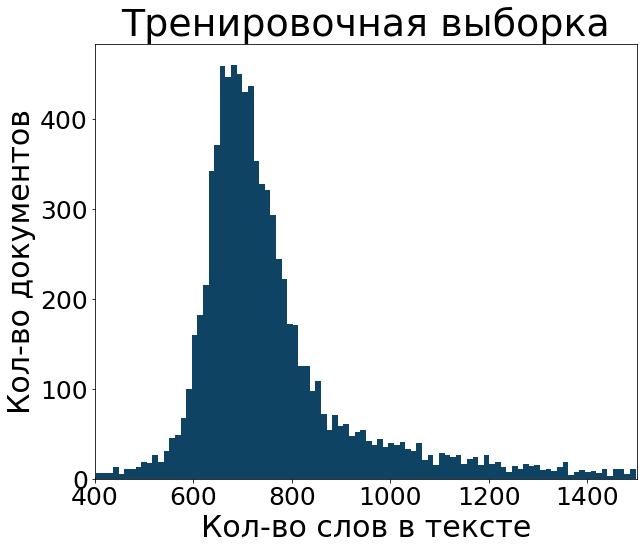

In [57]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = list(range(0, 1600, 200))

plt.subplots(figsize=(33, 8))

ax = plt.subplot(131)
ax.hist(lens, 100, color="#0e4363")
ax.set_ylabel("Кол-во документов", fontsize=30)
ax.set_xlabel("Кол-во слов в тексте", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(400,1500)
plt.title('Тренировочная выборка', fontsize=38)

In [58]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

x = np.random.randn(500)

fig = go.Figure(data=[go.Histogram(x=lens)])
fig.show()

In [59]:
lens = X_test['text'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0]))

In [60]:
X_test['text'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0])).mean()

762.5076263107721

Text(0.5, 1.0, 'Тестовая выборка')

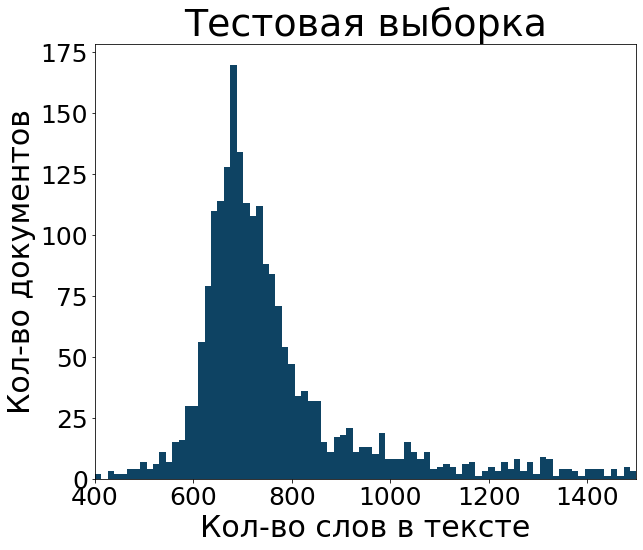

In [61]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = list(range(0, 1600, 200))

plt.subplots(figsize=(33, 8))

ax = plt.subplot(131)
ax.hist(lens, 100, color="#0e4363")
ax.set_ylabel("Кол-во документов", fontsize=30)
ax.set_xlabel("Кол-во слов в тексте", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(400,1500)
plt.title('Тестовая выборка', fontsize=38)

In [62]:
import plotly.graph_objects as go

import numpy as np
np.random.seed(1)

x = np.random.randn(500)

fig = go.Figure(data=[go.Histogram(x=lens)])
fig.show()

In [86]:
lens = X_train['summary'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0]))

In [87]:
X_train['summary'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0])).mean()

53.825148986889154

Text(0.5, 1.0, 'Тренировочная выборка')

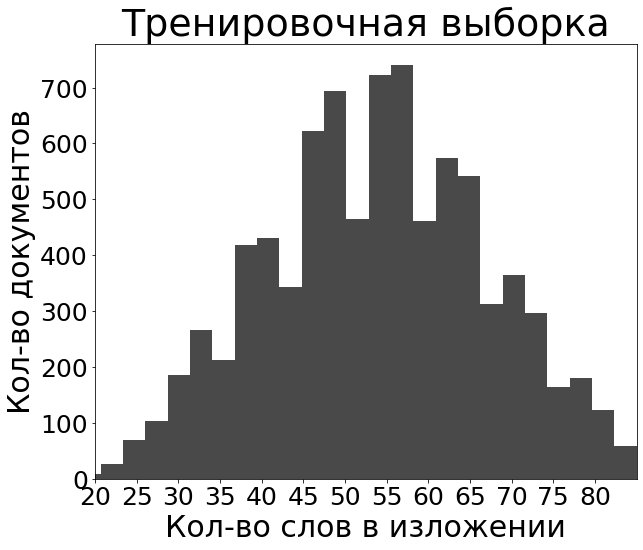

In [88]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = list(range(20, 85, 5))

plt.subplots(figsize=(33, 8))

ax = plt.subplot(131)
ax.hist(lens, 25, color="#494949")
ax.set_ylabel("Кол-во документов", fontsize=30)
ax.set_xlabel("Кол-во слов в изложении", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(20,85)
plt.title('Тренировочная выборка', fontsize=38)

In [82]:
lens = X_test['summary'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0]))

In [83]:
X_test['summary'].astype(str).apply(calc_text_words).apply(lambda x: len(x[0])).mean()

53.67445185891325

Text(0.5, 1.0, 'Тестовая выборка')

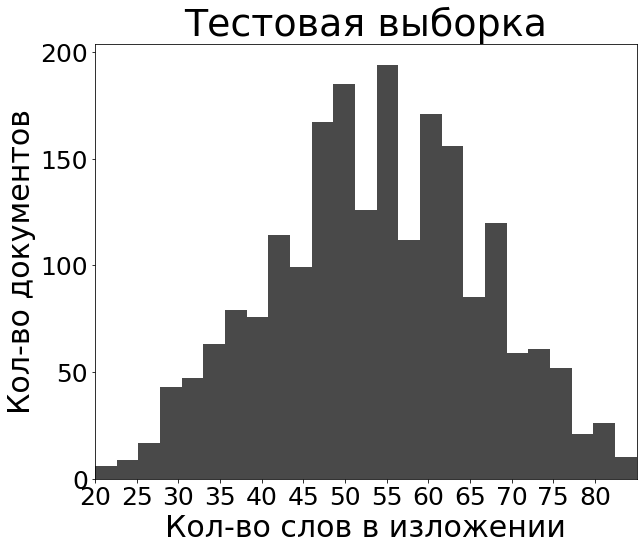

In [85]:
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = list(range(20, 85, 5))

plt.subplots(figsize=(33, 8))

ax = plt.subplot(131)
ax.hist(lens, 25, color="#494949")
ax.set_ylabel("Кол-во документов", fontsize=30)
ax.set_xlabel("Кол-во слов в изложении", fontsize=30)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(20, 85)
plt.title('Тестовая выборка', fontsize=38)

In [2]:
%%time

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data['clas'])
data['clas'] = le.transform(data['clas'])

CPU times: user 483 ms, sys: 267 ms, total: 750 ms
Wall time: 391 ms


In [3]:
%%time

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])

CPU times: user 13.7 ms, sys: 204 µs, total: 13.9 ms
Wall time: 13.5 ms


## Bag of words

In [5]:
%%time

from sklearn.feature_extraction.text import CountVectorizer

bof_vect = CountVectorizer(max_features=20000, max_df=0.95, min_df=5)
bof_vect.fit(df_w2v['text_lemma'])
bof_train = bof_vect.transform(X_train)
bof_test = bof_vect.transform(X_test)

CPU times: user 14.7 s, sys: 106 ms, total: 14.9 s
Wall time: 15.2 s


In [6]:
bof_train.shape

(8390, 20000)

## TF-IDF

In [7]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=20000, max_df=0.95, min_df=5)
tfidf_vect.fit(df_w2v['text_lemma'])
tfidf_train = tfidf_vect.transform(X_train).toarray()
tfidf_test = tfidf_vect.transform(X_test).toarray()

CPU times: user 15.5 s, sys: 536 ms, total: 16 s
Wall time: 16 s


In [8]:
tfidf_train.shape

(8390, 20000)

## Word2vec

In [9]:
%%time

from gensim.models import Word2Vec
X_train_w2v = X_train.apply(str.split)
X_test_w2v = X_test.apply(str.split)
#w2v_vect = Word2Vec(df_w2v['text_lemma'].apply(str.split),
#                    size=500,
#                    min_count=10,
#                    workers=8,
#                    sg = 0)

CPU times: user 824 ms, sys: 133 ms, total: 957 ms
Wall time: 2.56 s


import gensim.downloader as api

model = api.load("word2vec-ruscorpora-300")

from gensim.models import Word2Vec, KeyedVectors   
w2v_vect.wv.save_word2vec_format('word2vec-ruscorpora-300.bin', binary=True)

#18min 22s
from gensim.models import Word2Vec, KeyedVectors   
w2v_vect.wv.save_word2vec_format('w2v_model_cbow.bin', binary=True)

In [10]:
from gensim.models import KeyedVectors
word2vec_path = "word2vec-ruscorpora-300.bin"
w2v_vect = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [11]:
%%time

def text2vec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(w2v_vect[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)

w2v_train = X_train_w2v.apply(text2vec)
w2v_test = X_test_w2v.apply(text2vec)

CPU times: user 7.32 s, sys: 23.6 ms, total: 7.35 s
Wall time: 7.35 s


In [12]:
%%time

w2v_train = np.stack(w2v_train)
w2v_train.shape

CPU times: user 13.6 ms, sys: 4.08 ms, total: 17.7 ms
Wall time: 17.2 ms


(8390, 800)

In [13]:
%%time

w2v_test = np.stack(w2v_test)
w2v_test.shape

CPU times: user 4.18 ms, sys: 0 ns, total: 4.18 ms
Wall time: 4.02 ms


(2098, 800)

## Navec

!pip install navec

!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

In [27]:
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
X_train_nav = X_train.apply(str.split)
X_test_nav = X_test.apply(str.split)

In [28]:
%%time

def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
navec_train = X_train_nav.apply(text2vec_navec)
navec_test = X_test_nav.apply(text2vec_navec)

CPU times: user 21.5 s, sys: 0 ns, total: 21.5 s
Wall time: 21.5 s


In [29]:
%%time

navec_train = np.stack(navec_train)
navec_train.shape

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 10.3 ms


(8390, 300)

In [30]:
%%time

navec_test = np.stack(navec_test)
navec_test.shape

CPU times: user 4.75 ms, sys: 0 ns, total: 4.75 ms
Wall time: 4.58 ms


(2098, 300)

In [13]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
a = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      )\
.fit(w2v_train, y_train,eval_set=Pool(w2v_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9936490	test: 1.9967387	best: 1.9967387 (0)	total: 411ms	remaining: 5m 28s
1:	learn: 1.9164766	test: 1.9226657	best: 1.9226657 (1)	total: 821ms	remaining: 5m 27s
2:	learn: 1.8485356	test: 1.8578787	best: 1.8578787 (2)	total: 1.23s	remaining: 5m 26s
3:	learn: 1.7886424	test: 1.8002954	best: 1.8002954 (3)	total: 1.61s	remaining: 5m 21s
4:	learn: 1.7336389	test: 1.7465318	best: 1.7465318 (4)	total: 2.02s	remaining: 5m 21s
5:	learn: 1.6762977	test: 1.6913852	best: 1.6913852 (5)	total: 2.35s	remaining: 5m 11s
6:	learn: 1.6264185	test: 1.6431624	best: 1.6431624 (6)	total: 2.74s	remaining: 5m 9s
7:	learn: 1.5769934	test: 1.5952018	best: 1.5952018 (7)	total: 3.09s	remaining: 5m 6s
8:	learn: 1.5322444	test: 1.5515530	best: 1.5515530 (8)	total: 3.46s	remaining: 5m 3s
9:	learn: 1.4921071	test: 1.5134802	best: 1.5134802 (9)	total: 3.83s	remaining: 5m 2s
10:	learn: 1.4530313	test: 1.4758445	best: 1.4758445 (10)	total: 4.2s	remaining: 5m 1s
11:	learn: 1.4154192	test: 1.4397643	best: 1.43

93:	learn: 0.4919947	test: 0.6000274	best: 0.6000274 (93)	total: 36s	remaining: 4m 30s
94:	learn: 0.4885083	test: 0.5971063	best: 0.5971063 (94)	total: 36.4s	remaining: 4m 30s
95:	learn: 0.4850425	test: 0.5943867	best: 0.5943867 (95)	total: 36.8s	remaining: 4m 29s
96:	learn: 0.4816800	test: 0.5916687	best: 0.5916687 (96)	total: 37.2s	remaining: 4m 29s
97:	learn: 0.4780598	test: 0.5888137	best: 0.5888137 (97)	total: 37.6s	remaining: 4m 28s
98:	learn: 0.4748215	test: 0.5863044	best: 0.5863044 (98)	total: 37.9s	remaining: 4m 28s
99:	learn: 0.4714836	test: 0.5839786	best: 0.5839786 (99)	total: 38.3s	remaining: 4m 28s
100:	learn: 0.4680591	test: 0.5811821	best: 0.5811821 (100)	total: 38.7s	remaining: 4m 27s
101:	learn: 0.4646878	test: 0.5786438	best: 0.5786438 (101)	total: 39.1s	remaining: 4m 27s
102:	learn: 0.4615081	test: 0.5761064	best: 0.5761064 (102)	total: 39.4s	remaining: 4m 26s
103:	learn: 0.4583298	test: 0.5736853	best: 0.5736853 (103)	total: 39.8s	remaining: 4m 26s
104:	learn: 0.4

184:	learn: 0.2977458	test: 0.4619590	best: 0.4619590 (184)	total: 1m 10s	remaining: 3m 52s
185:	learn: 0.2964108	test: 0.4611441	best: 0.4611441 (185)	total: 1m 10s	remaining: 3m 52s
186:	learn: 0.2951368	test: 0.4604617	best: 0.4604617 (186)	total: 1m 10s	remaining: 3m 51s
187:	learn: 0.2938247	test: 0.4599336	best: 0.4599336 (187)	total: 1m 11s	remaining: 3m 51s
188:	learn: 0.2925461	test: 0.4590261	best: 0.4590261 (188)	total: 1m 11s	remaining: 3m 51s
189:	learn: 0.2913291	test: 0.4582310	best: 0.4582310 (189)	total: 1m 11s	remaining: 3m 50s
190:	learn: 0.2901062	test: 0.4575297	best: 0.4575297 (190)	total: 1m 12s	remaining: 3m 50s
191:	learn: 0.2888457	test: 0.4568236	best: 0.4568236 (191)	total: 1m 12s	remaining: 3m 49s
192:	learn: 0.2877679	test: 0.4560111	best: 0.4560111 (192)	total: 1m 12s	remaining: 3m 49s
193:	learn: 0.2866222	test: 0.4551757	best: 0.4551757 (193)	total: 1m 13s	remaining: 3m 48s
194:	learn: 0.2855431	test: 0.4544479	best: 0.4544479 (194)	total: 1m 13s	remain

274:	learn: 0.2167312	test: 0.4133685	best: 0.4133685 (274)	total: 1m 39s	remaining: 3m 9s
275:	learn: 0.2160319	test: 0.4130202	best: 0.4130202 (275)	total: 1m 39s	remaining: 3m 9s
276:	learn: 0.2154513	test: 0.4125647	best: 0.4125647 (276)	total: 1m 40s	remaining: 3m 8s
277:	learn: 0.2148514	test: 0.4122426	best: 0.4122426 (277)	total: 1m 40s	remaining: 3m 8s
278:	learn: 0.2141129	test: 0.4117074	best: 0.4117074 (278)	total: 1m 40s	remaining: 3m 8s
279:	learn: 0.2135832	test: 0.4114721	best: 0.4114721 (279)	total: 1m 40s	remaining: 3m 7s
280:	learn: 0.2129940	test: 0.4110395	best: 0.4110395 (280)	total: 1m 41s	remaining: 3m 7s
281:	learn: 0.2123874	test: 0.4107477	best: 0.4107477 (281)	total: 1m 41s	remaining: 3m 6s
282:	learn: 0.2118013	test: 0.4104276	best: 0.4104276 (282)	total: 1m 41s	remaining: 3m 6s
283:	learn: 0.2111603	test: 0.4100314	best: 0.4100314 (283)	total: 1m 42s	remaining: 3m 5s
284:	learn: 0.2106567	test: 0.4097877	best: 0.4097877 (284)	total: 1m 42s	remaining: 3m 5s

364:	learn: 0.1720784	test: 0.3888824	best: 0.3888824 (364)	total: 2m 6s	remaining: 2m 30s
365:	learn: 0.1718746	test: 0.3887785	best: 0.3887785 (365)	total: 2m 6s	remaining: 2m 30s
366:	learn: 0.1714677	test: 0.3885285	best: 0.3885285 (366)	total: 2m 6s	remaining: 2m 29s
367:	learn: 0.1710995	test: 0.3883115	best: 0.3883115 (367)	total: 2m 7s	remaining: 2m 29s
368:	learn: 0.1706355	test: 0.3881062	best: 0.3881062 (368)	total: 2m 7s	remaining: 2m 28s
369:	learn: 0.1701672	test: 0.3877878	best: 0.3877878 (369)	total: 2m 7s	remaining: 2m 28s
370:	learn: 0.1698377	test: 0.3875557	best: 0.3875557 (370)	total: 2m 7s	remaining: 2m 27s
371:	learn: 0.1695624	test: 0.3873034	best: 0.3873034 (371)	total: 2m 8s	remaining: 2m 27s
372:	learn: 0.1692974	test: 0.3870788	best: 0.3870788 (372)	total: 2m 8s	remaining: 2m 27s
373:	learn: 0.1689363	test: 0.3869589	best: 0.3869589 (373)	total: 2m 8s	remaining: 2m 26s
374:	learn: 0.1685821	test: 0.3867420	best: 0.3867420 (374)	total: 2m 9s	remaining: 2m 26s

454:	learn: 0.1438005	test: 0.3737279	best: 0.3737279 (454)	total: 2m 31s	remaining: 1m 55s
455:	learn: 0.1435579	test: 0.3735014	best: 0.3735014 (455)	total: 2m 32s	remaining: 1m 54s
456:	learn: 0.1433618	test: 0.3733825	best: 0.3733825 (456)	total: 2m 32s	remaining: 1m 54s
457:	learn: 0.1431784	test: 0.3732918	best: 0.3732918 (457)	total: 2m 32s	remaining: 1m 54s
458:	learn: 0.1429865	test: 0.3730736	best: 0.3730736 (458)	total: 2m 32s	remaining: 1m 53s
459:	learn: 0.1427167	test: 0.3729341	best: 0.3729341 (459)	total: 2m 33s	remaining: 1m 53s
460:	learn: 0.1424633	test: 0.3728180	best: 0.3728180 (460)	total: 2m 33s	remaining: 1m 52s
461:	learn: 0.1421777	test: 0.3726120	best: 0.3726120 (461)	total: 2m 33s	remaining: 1m 52s
462:	learn: 0.1419844	test: 0.3725340	best: 0.3725340 (462)	total: 2m 34s	remaining: 1m 52s
463:	learn: 0.1415973	test: 0.3722925	best: 0.3722925 (463)	total: 2m 34s	remaining: 1m 51s
464:	learn: 0.1414149	test: 0.3721439	best: 0.3721439 (464)	total: 2m 34s	remain

544:	learn: 0.1233664	test: 0.3633781	best: 0.3633781 (544)	total: 2m 56s	remaining: 1m 22s
545:	learn: 0.1231085	test: 0.3632186	best: 0.3632186 (545)	total: 2m 57s	remaining: 1m 22s
546:	learn: 0.1228665	test: 0.3631243	best: 0.3631243 (546)	total: 2m 57s	remaining: 1m 22s
547:	learn: 0.1226639	test: 0.3629139	best: 0.3629139 (547)	total: 2m 57s	remaining: 1m 21s
548:	learn: 0.1224479	test: 0.3628048	best: 0.3628048 (548)	total: 2m 58s	remaining: 1m 21s
549:	learn: 0.1222126	test: 0.3627051	best: 0.3627051 (549)	total: 2m 58s	remaining: 1m 21s
550:	learn: 0.1220169	test: 0.3626083	best: 0.3626083 (550)	total: 2m 58s	remaining: 1m 20s
551:	learn: 0.1217908	test: 0.3624843	best: 0.3624843 (551)	total: 2m 58s	remaining: 1m 20s
552:	learn: 0.1216381	test: 0.3623518	best: 0.3623518 (552)	total: 2m 59s	remaining: 1m 20s
553:	learn: 0.1213239	test: 0.3622364	best: 0.3622364 (553)	total: 2m 59s	remaining: 1m 19s
554:	learn: 0.1211255	test: 0.3621344	best: 0.3621344 (554)	total: 2m 59s	remain

635:	learn: 0.1069230	test: 0.3551891	best: 0.3551891 (635)	total: 3m 22s	remaining: 52.2s
636:	learn: 0.1067587	test: 0.3551211	best: 0.3551211 (636)	total: 3m 22s	remaining: 51.8s
637:	learn: 0.1065991	test: 0.3550870	best: 0.3550870 (637)	total: 3m 22s	remaining: 51.5s
638:	learn: 0.1064335	test: 0.3549807	best: 0.3549807 (638)	total: 3m 23s	remaining: 51.2s
639:	learn: 0.1062707	test: 0.3549430	best: 0.3549430 (639)	total: 3m 23s	remaining: 50.8s
640:	learn: 0.1060847	test: 0.3548953	best: 0.3548953 (640)	total: 3m 23s	remaining: 50.5s
641:	learn: 0.1059563	test: 0.3548084	best: 0.3548084 (641)	total: 3m 23s	remaining: 50.2s
642:	learn: 0.1058168	test: 0.3547188	best: 0.3547188 (642)	total: 3m 24s	remaining: 49.9s
643:	learn: 0.1056451	test: 0.3546525	best: 0.3546525 (643)	total: 3m 24s	remaining: 49.5s
644:	learn: 0.1054766	test: 0.3544896	best: 0.3544896 (644)	total: 3m 24s	remaining: 49.2s
645:	learn: 0.1053117	test: 0.3543285	best: 0.3543285 (645)	total: 3m 24s	remaining: 48.9s

726:	learn: 0.0939285	test: 0.3492481	best: 0.3492481 (726)	total: 3m 47s	remaining: 22.8s
727:	learn: 0.0938448	test: 0.3492197	best: 0.3492197 (727)	total: 3m 47s	remaining: 22.5s
728:	learn: 0.0936819	test: 0.3491678	best: 0.3491678 (728)	total: 3m 47s	remaining: 22.2s
729:	learn: 0.0935779	test: 0.3490970	best: 0.3490970 (729)	total: 3m 48s	remaining: 21.9s
730:	learn: 0.0935085	test: 0.3490526	best: 0.3490526 (730)	total: 3m 48s	remaining: 21.6s
731:	learn: 0.0933649	test: 0.3489822	best: 0.3489822 (731)	total: 3m 48s	remaining: 21.2s
732:	learn: 0.0932290	test: 0.3489403	best: 0.3489403 (732)	total: 3m 48s	remaining: 20.9s
733:	learn: 0.0930185	test: 0.3488626	best: 0.3488626 (733)	total: 3m 49s	remaining: 20.6s
734:	learn: 0.0928832	test: 0.3488125	best: 0.3488125 (734)	total: 3m 49s	remaining: 20.3s
735:	learn: 0.0927943	test: 0.3487587	best: 0.3487587 (735)	total: 3m 49s	remaining: 20s
736:	learn: 0.0927091	test: 0.3487560	best: 0.3487560 (736)	total: 3m 50s	remaining: 19.7s
7

In [30]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

ros = RandomOverSampler(random_state=8)
w2v_train_resampled_ros, y_resampled_ros = ros.fit_resample(w2v_train, y_train)

sm = SMOTE(sampling_strategy='minority')
w2v_train_resampled_sm, y_resampled_sm = sm.fit_resample(w2v_train, y_train)

ad = ADASYN(sampling_strategy='minority')
w2v_train_resampled_ad, y_resampled_ad = ad.fit_resample(w2v_train, y_train)



In [31]:
from sklearn import svm

SVM_ros = svm.SVC(kernel='linear', gamma='auto')
SVM_ros.fit(w2v_train_resampled_ros, y_resampled_ros)

SVM_sm = svm.SVC(kernel='linear', gamma='auto')
SVM_sm.fit(w2v_train_resampled_sm, y_resampled_sm)

SVM_ad = svm.SVC(kernel='linear', gamma='auto')
SVM_ad.fit(w2v_train_resampled_ad, y_resampled_ad)

SVM = svm.SVC(kernel='linear', gamma='auto')
SVM.fit(w2v_train, y_train)

SVC(gamma='auto', kernel='linear')

In [16]:
ros_cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      ).fit(w2v_train_resampled_ros, y_resampled_ros,eval_set=Pool(w2v_test, y_test))
sm_cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      ).fit(w2v_train_resampled_sm, y_resampled_sm,eval_set=Pool(w2v_test, y_test))
ad_cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      ).fit(w2v_train_resampled_ad, y_resampled_ad,eval_set=Pool(w2v_test, y_test))

0:	learn: 1.9855909	test: 1.9946312	best: 1.9946312 (0)	total: 404ms	remaining: 5m 22s
1:	learn: 1.9007829	test: 1.9202465	best: 1.9202465 (1)	total: 815ms	remaining: 5m 25s
2:	learn: 1.8244801	test: 1.8535237	best: 1.8535237 (2)	total: 1.23s	remaining: 5m 25s
3:	learn: 1.7545036	test: 1.7925631	best: 1.7925631 (3)	total: 1.62s	remaining: 5m 22s
4:	learn: 1.6902743	test: 1.7343892	best: 1.7343892 (4)	total: 2.02s	remaining: 5m 21s
5:	learn: 1.6322399	test: 1.6811045	best: 1.6811045 (5)	total: 2.4s	remaining: 5m 17s
6:	learn: 1.5805317	test: 1.6355143	best: 1.6355143 (6)	total: 2.79s	remaining: 5m 16s
7:	learn: 1.5313221	test: 1.5896499	best: 1.5896499 (7)	total: 3.2s	remaining: 5m 16s
8:	learn: 1.4833642	test: 1.5457811	best: 1.5457811 (8)	total: 3.57s	remaining: 5m 14s
9:	learn: 1.4382658	test: 1.5041205	best: 1.5041205 (9)	total: 3.95s	remaining: 5m 12s
10:	learn: 1.3966751	test: 1.4661551	best: 1.4661551 (10)	total: 4.34s	remaining: 5m 11s
11:	learn: 1.3576552	test: 1.4305240	best: 

93:	learn: 0.3932981	test: 0.5820641	best: 0.5820641 (93)	total: 36.5s	remaining: 4m 34s
94:	learn: 0.3897283	test: 0.5793484	best: 0.5793484 (94)	total: 36.9s	remaining: 4m 33s
95:	learn: 0.3860242	test: 0.5761062	best: 0.5761062 (95)	total: 37.2s	remaining: 4m 33s
96:	learn: 0.3825698	test: 0.5735740	best: 0.5735740 (96)	total: 37.7s	remaining: 4m 33s
97:	learn: 0.3792361	test: 0.5709333	best: 0.5709333 (97)	total: 38.1s	remaining: 4m 32s
98:	learn: 0.3761396	test: 0.5685693	best: 0.5685693 (98)	total: 38.5s	remaining: 4m 32s
99:	learn: 0.3729505	test: 0.5659888	best: 0.5659888 (99)	total: 38.9s	remaining: 4m 32s
100:	learn: 0.3696846	test: 0.5633451	best: 0.5633451 (100)	total: 39.3s	remaining: 4m 32s
101:	learn: 0.3665831	test: 0.5608839	best: 0.5608839 (101)	total: 39.8s	remaining: 4m 32s
102:	learn: 0.3635596	test: 0.5582671	best: 0.5582671 (102)	total: 40.2s	remaining: 4m 31s
103:	learn: 0.3604973	test: 0.5560377	best: 0.5560377 (103)	total: 40.6s	remaining: 4m 31s
104:	learn: 0

184:	learn: 0.2142332	test: 0.4447421	best: 0.4447421 (184)	total: 1m 11s	remaining: 3m 58s
185:	learn: 0.2132194	test: 0.4438216	best: 0.4438216 (185)	total: 1m 12s	remaining: 3m 58s
186:	learn: 0.2124029	test: 0.4430497	best: 0.4430497 (186)	total: 1m 12s	remaining: 3m 57s
187:	learn: 0.2115483	test: 0.4421885	best: 0.4421885 (187)	total: 1m 12s	remaining: 3m 56s
188:	learn: 0.2104781	test: 0.4414710	best: 0.4414710 (188)	total: 1m 13s	remaining: 3m 56s
189:	learn: 0.2094301	test: 0.4407363	best: 0.4407363 (189)	total: 1m 13s	remaining: 3m 56s
190:	learn: 0.2084812	test: 0.4398796	best: 0.4398796 (190)	total: 1m 13s	remaining: 3m 55s
191:	learn: 0.2073630	test: 0.4391316	best: 0.4391316 (191)	total: 1m 14s	remaining: 3m 55s
192:	learn: 0.2065007	test: 0.4383603	best: 0.4383603 (192)	total: 1m 14s	remaining: 3m 54s
193:	learn: 0.2054727	test: 0.4375917	best: 0.4375917 (193)	total: 1m 14s	remaining: 3m 54s
194:	learn: 0.2045090	test: 0.4368210	best: 0.4368210 (194)	total: 1m 15s	remain

274:	learn: 0.1523980	test: 0.3991272	best: 0.3991272 (274)	total: 1m 40s	remaining: 3m 12s
275:	learn: 0.1518430	test: 0.3987604	best: 0.3987604 (275)	total: 1m 41s	remaining: 3m 11s
276:	learn: 0.1513591	test: 0.3984192	best: 0.3984192 (276)	total: 1m 41s	remaining: 3m 11s
277:	learn: 0.1508538	test: 0.3980115	best: 0.3980115 (277)	total: 1m 41s	remaining: 3m 10s
278:	learn: 0.1503392	test: 0.3976625	best: 0.3976625 (278)	total: 1m 42s	remaining: 3m 10s
279:	learn: 0.1499430	test: 0.3973526	best: 0.3973526 (279)	total: 1m 42s	remaining: 3m 9s
280:	learn: 0.1495096	test: 0.3970953	best: 0.3970953 (280)	total: 1m 42s	remaining: 3m 9s
281:	learn: 0.1490668	test: 0.3967317	best: 0.3967317 (281)	total: 1m 42s	remaining: 3m 9s
282:	learn: 0.1485559	test: 0.3964038	best: 0.3964038 (282)	total: 1m 43s	remaining: 3m 8s
283:	learn: 0.1481966	test: 0.3960984	best: 0.3960984 (283)	total: 1m 43s	remaining: 3m 8s
284:	learn: 0.1478130	test: 0.3958382	best: 0.3958382 (284)	total: 1m 43s	remaining: 

364:	learn: 0.1209557	test: 0.3769158	best: 0.3769158 (364)	total: 2m 6s	remaining: 2m 31s
365:	learn: 0.1207156	test: 0.3767744	best: 0.3767744 (365)	total: 2m 7s	remaining: 2m 30s
366:	learn: 0.1203542	test: 0.3765229	best: 0.3765229 (366)	total: 2m 7s	remaining: 2m 30s
367:	learn: 0.1200917	test: 0.3763374	best: 0.3763374 (367)	total: 2m 7s	remaining: 2m 30s
368:	learn: 0.1198329	test: 0.3762539	best: 0.3762539 (368)	total: 2m 8s	remaining: 2m 29s
369:	learn: 0.1195930	test: 0.3760079	best: 0.3760079 (369)	total: 2m 8s	remaining: 2m 29s
370:	learn: 0.1193299	test: 0.3758317	best: 0.3758317 (370)	total: 2m 8s	remaining: 2m 28s
371:	learn: 0.1190071	test: 0.3755836	best: 0.3755836 (371)	total: 2m 9s	remaining: 2m 28s
372:	learn: 0.1187675	test: 0.3754769	best: 0.3754769 (372)	total: 2m 9s	remaining: 2m 28s
373:	learn: 0.1185483	test: 0.3753732	best: 0.3753732 (373)	total: 2m 9s	remaining: 2m 27s
374:	learn: 0.1182845	test: 0.3752343	best: 0.3752343 (374)	total: 2m 9s	remaining: 2m 27s

454:	learn: 0.1010126	test: 0.3632931	best: 0.3632931 (454)	total: 2m 32s	remaining: 1m 55s
455:	learn: 0.1008894	test: 0.3632000	best: 0.3632000 (455)	total: 2m 32s	remaining: 1m 55s
456:	learn: 0.1007112	test: 0.3631155	best: 0.3631155 (456)	total: 2m 32s	remaining: 1m 54s
457:	learn: 0.1004631	test: 0.3629675	best: 0.3629675 (457)	total: 2m 33s	remaining: 1m 54s
458:	learn: 0.1003654	test: 0.3629011	best: 0.3629011 (458)	total: 2m 33s	remaining: 1m 53s
459:	learn: 0.1001689	test: 0.3628159	best: 0.3628159 (459)	total: 2m 33s	remaining: 1m 53s
460:	learn: 0.0999647	test: 0.3626927	best: 0.3626927 (460)	total: 2m 33s	remaining: 1m 53s
461:	learn: 0.0998352	test: 0.3625024	best: 0.3625024 (461)	total: 2m 34s	remaining: 1m 52s
462:	learn: 0.0997354	test: 0.3624248	best: 0.3624248 (462)	total: 2m 34s	remaining: 1m 52s
463:	learn: 0.0995610	test: 0.3623066	best: 0.3623066 (463)	total: 2m 34s	remaining: 1m 52s
464:	learn: 0.0993690	test: 0.3621586	best: 0.3621586 (464)	total: 2m 35s	remain

544:	learn: 0.0873440	test: 0.3551148	best: 0.3551148 (544)	total: 2m 56s	remaining: 1m 22s
545:	learn: 0.0871834	test: 0.3550266	best: 0.3550266 (545)	total: 2m 57s	remaining: 1m 22s
546:	learn: 0.0870372	test: 0.3549750	best: 0.3549750 (546)	total: 2m 57s	remaining: 1m 22s
547:	learn: 0.0869095	test: 0.3548727	best: 0.3548727 (547)	total: 2m 57s	remaining: 1m 21s
548:	learn: 0.0867987	test: 0.3547583	best: 0.3547583 (548)	total: 2m 57s	remaining: 1m 21s
549:	learn: 0.0866692	test: 0.3546417	best: 0.3546417 (549)	total: 2m 58s	remaining: 1m 21s
550:	learn: 0.0865443	test: 0.3545987	best: 0.3545987 (550)	total: 2m 58s	remaining: 1m 20s
551:	learn: 0.0863774	test: 0.3545188	best: 0.3545188 (551)	total: 2m 58s	remaining: 1m 20s
552:	learn: 0.0863030	test: 0.3545035	best: 0.3545035 (552)	total: 2m 59s	remaining: 1m 20s
553:	learn: 0.0861538	test: 0.3544178	best: 0.3544178 (553)	total: 2m 59s	remaining: 1m 19s
554:	learn: 0.0860465	test: 0.3543970	best: 0.3543970 (554)	total: 2m 59s	remain

635:	learn: 0.0764353	test: 0.3485646	best: 0.3485646 (635)	total: 3m 21s	remaining: 51.9s
636:	learn: 0.0763403	test: 0.3485788	best: 0.3485646 (635)	total: 3m 21s	remaining: 51.6s
637:	learn: 0.0762159	test: 0.3485036	best: 0.3485036 (637)	total: 3m 21s	remaining: 51.3s
638:	learn: 0.0760921	test: 0.3485144	best: 0.3485036 (637)	total: 3m 22s	remaining: 50.9s
639:	learn: 0.0760136	test: 0.3484716	best: 0.3484716 (639)	total: 3m 22s	remaining: 50.6s
640:	learn: 0.0758771	test: 0.3484099	best: 0.3484099 (640)	total: 3m 22s	remaining: 50.3s
641:	learn: 0.0757985	test: 0.3483773	best: 0.3483773 (641)	total: 3m 23s	remaining: 50s
642:	learn: 0.0756807	test: 0.3483287	best: 0.3483287 (642)	total: 3m 23s	remaining: 49.6s
643:	learn: 0.0756058	test: 0.3483002	best: 0.3483002 (643)	total: 3m 23s	remaining: 49.3s
644:	learn: 0.0755308	test: 0.3482064	best: 0.3482064 (644)	total: 3m 23s	remaining: 49s
645:	learn: 0.0754505	test: 0.3482052	best: 0.3482052 (645)	total: 3m 24s	remaining: 48.6s
646

726:	learn: 0.0680936	test: 0.3439460	best: 0.3439145 (725)	total: 3m 45s	remaining: 22.7s
727:	learn: 0.0680072	test: 0.3439230	best: 0.3439145 (725)	total: 3m 46s	remaining: 22.4s
728:	learn: 0.0679485	test: 0.3438545	best: 0.3438545 (728)	total: 3m 46s	remaining: 22s
729:	learn: 0.0678889	test: 0.3437949	best: 0.3437949 (729)	total: 3m 46s	remaining: 21.7s
730:	learn: 0.0677620	test: 0.3437668	best: 0.3437668 (730)	total: 3m 46s	remaining: 21.4s
731:	learn: 0.0676934	test: 0.3437489	best: 0.3437489 (731)	total: 3m 47s	remaining: 21.1s
732:	learn: 0.0675859	test: 0.3437121	best: 0.3437121 (732)	total: 3m 47s	remaining: 20.8s
733:	learn: 0.0674811	test: 0.3436705	best: 0.3436705 (733)	total: 3m 47s	remaining: 20.5s
734:	learn: 0.0674077	test: 0.3436504	best: 0.3436504 (734)	total: 3m 48s	remaining: 20.2s
735:	learn: 0.0673766	test: 0.3436336	best: 0.3436336 (735)	total: 3m 48s	remaining: 19.9s
736:	learn: 0.0672681	test: 0.3436121	best: 0.3436121 (736)	total: 3m 48s	remaining: 19.5s
7

17:	learn: 1.2045844	test: 1.2790869	best: 1.2790869 (17)	total: 6.94s	remaining: 5m 1s
18:	learn: 1.1771086	test: 1.2536483	best: 1.2536483 (18)	total: 7.26s	remaining: 4m 58s
19:	learn: 1.1517461	test: 1.2293281	best: 1.2293281 (19)	total: 7.64s	remaining: 4m 57s
20:	learn: 1.1277246	test: 1.2077212	best: 1.2077212 (20)	total: 8.01s	remaining: 4m 57s
21:	learn: 1.1047494	test: 1.1865167	best: 1.1865167 (21)	total: 8.4s	remaining: 4m 56s
22:	learn: 1.0826221	test: 1.1667192	best: 1.1667192 (22)	total: 8.79s	remaining: 4m 56s
23:	learn: 1.0612070	test: 1.1476041	best: 1.1476041 (23)	total: 9.16s	remaining: 4m 56s
24:	learn: 1.0415877	test: 1.1298302	best: 1.1298302 (24)	total: 9.55s	remaining: 4m 56s
25:	learn: 1.0218509	test: 1.1112620	best: 1.1112620 (25)	total: 9.92s	remaining: 4m 55s
26:	learn: 1.0025301	test: 1.0933603	best: 1.0933603 (26)	total: 10.3s	remaining: 4m 54s
27:	learn: 0.9843539	test: 1.0768277	best: 1.0768277 (27)	total: 10.6s	remaining: 4m 53s
28:	learn: 0.9678601	te

110:	learn: 0.4006343	test: 0.5591954	best: 0.5591954 (110)	total: 42.6s	remaining: 4m 24s
111:	learn: 0.3978624	test: 0.5567947	best: 0.5567947 (111)	total: 43s	remaining: 4m 23s
112:	learn: 0.3950985	test: 0.5544849	best: 0.5544849 (112)	total: 43.3s	remaining: 4m 23s
113:	learn: 0.3925830	test: 0.5526852	best: 0.5526852 (113)	total: 43.7s	remaining: 4m 23s
114:	learn: 0.3898361	test: 0.5505051	best: 0.5505051 (114)	total: 44.1s	remaining: 4m 22s
115:	learn: 0.3871722	test: 0.5484001	best: 0.5484001 (115)	total: 44.5s	remaining: 4m 22s
116:	learn: 0.3846626	test: 0.5464287	best: 0.5464287 (116)	total: 44.9s	remaining: 4m 22s
117:	learn: 0.3821059	test: 0.5443886	best: 0.5443886 (117)	total: 45.3s	remaining: 4m 21s
118:	learn: 0.3795735	test: 0.5424725	best: 0.5424725 (118)	total: 45.7s	remaining: 4m 21s
119:	learn: 0.3772004	test: 0.5406182	best: 0.5406182 (119)	total: 46.1s	remaining: 4m 21s
120:	learn: 0.3747429	test: 0.5385853	best: 0.5385853 (120)	total: 46.4s	remaining: 4m 20s
1

201:	learn: 0.2475914	test: 0.4453197	best: 0.4453197 (201)	total: 1m 16s	remaining: 3m 45s
202:	learn: 0.2465236	test: 0.4447321	best: 0.4447321 (202)	total: 1m 16s	remaining: 3m 45s
203:	learn: 0.2455705	test: 0.4440659	best: 0.4440659 (203)	total: 1m 16s	remaining: 3m 44s
204:	learn: 0.2446298	test: 0.4434894	best: 0.4434894 (204)	total: 1m 17s	remaining: 3m 44s
205:	learn: 0.2436317	test: 0.4428346	best: 0.4428346 (205)	total: 1m 17s	remaining: 3m 43s
206:	learn: 0.2426580	test: 0.4422700	best: 0.4422700 (206)	total: 1m 18s	remaining: 3m 43s
207:	learn: 0.2415199	test: 0.4414981	best: 0.4414981 (207)	total: 1m 18s	remaining: 3m 43s
208:	learn: 0.2405599	test: 0.4408245	best: 0.4408245 (208)	total: 1m 18s	remaining: 3m 42s
209:	learn: 0.2397235	test: 0.4401089	best: 0.4401089 (209)	total: 1m 19s	remaining: 3m 42s
210:	learn: 0.2386677	test: 0.4395151	best: 0.4395151 (210)	total: 1m 19s	remaining: 3m 41s
211:	learn: 0.2377322	test: 0.4389521	best: 0.4389521 (211)	total: 1m 19s	remain

291:	learn: 0.1824064	test: 0.4030120	best: 0.4030120 (291)	total: 1m 45s	remaining: 3m 3s
292:	learn: 0.1819737	test: 0.4026831	best: 0.4026831 (292)	total: 1m 45s	remaining: 3m 3s
293:	learn: 0.1814403	test: 0.4023611	best: 0.4023611 (293)	total: 1m 46s	remaining: 3m 2s
294:	learn: 0.1809495	test: 0.4021116	best: 0.4021116 (294)	total: 1m 46s	remaining: 3m 2s
295:	learn: 0.1805473	test: 0.4017385	best: 0.4017385 (295)	total: 1m 46s	remaining: 3m 2s
296:	learn: 0.1800119	test: 0.4014019	best: 0.4014019 (296)	total: 1m 47s	remaining: 3m 1s
297:	learn: 0.1795918	test: 0.4011639	best: 0.4011639 (297)	total: 1m 47s	remaining: 3m 1s
298:	learn: 0.1791803	test: 0.4007876	best: 0.4007876 (298)	total: 1m 47s	remaining: 3m
299:	learn: 0.1787196	test: 0.4005013	best: 0.4005013 (299)	total: 1m 48s	remaining: 3m
300:	learn: 0.1783692	test: 0.4001863	best: 0.4001863 (300)	total: 1m 48s	remaining: 2m 59s
301:	learn: 0.1779288	test: 0.3998962	best: 0.3998962 (301)	total: 1m 48s	remaining: 2m 59s
302

381:	learn: 0.1468676	test: 0.3816344	best: 0.3816344 (381)	total: 2m 12s	remaining: 2m 24s
382:	learn: 0.1464787	test: 0.3814506	best: 0.3814506 (382)	total: 2m 12s	remaining: 2m 24s
383:	learn: 0.1461527	test: 0.3812785	best: 0.3812785 (383)	total: 2m 13s	remaining: 2m 24s
384:	learn: 0.1457542	test: 0.3810086	best: 0.3810086 (384)	total: 2m 13s	remaining: 2m 23s
385:	learn: 0.1453985	test: 0.3808170	best: 0.3808170 (385)	total: 2m 13s	remaining: 2m 23s
386:	learn: 0.1451882	test: 0.3807174	best: 0.3807174 (386)	total: 2m 14s	remaining: 2m 23s
387:	learn: 0.1449257	test: 0.3805804	best: 0.3805804 (387)	total: 2m 14s	remaining: 2m 22s
388:	learn: 0.1446634	test: 0.3803302	best: 0.3803302 (388)	total: 2m 14s	remaining: 2m 22s
389:	learn: 0.1443286	test: 0.3800968	best: 0.3800968 (389)	total: 2m 14s	remaining: 2m 21s
390:	learn: 0.1440506	test: 0.3799113	best: 0.3799113 (390)	total: 2m 15s	remaining: 2m 21s
391:	learn: 0.1437466	test: 0.3797982	best: 0.3797982 (391)	total: 2m 15s	remain

471:	learn: 0.1229285	test: 0.3681898	best: 0.3681898 (471)	total: 2m 38s	remaining: 1m 50s
472:	learn: 0.1226918	test: 0.3680730	best: 0.3680730 (472)	total: 2m 38s	remaining: 1m 49s
473:	learn: 0.1224979	test: 0.3679486	best: 0.3679486 (473)	total: 2m 39s	remaining: 1m 49s
474:	learn: 0.1222306	test: 0.3678303	best: 0.3678303 (474)	total: 2m 39s	remaining: 1m 49s
475:	learn: 0.1220365	test: 0.3677971	best: 0.3677971 (475)	total: 2m 39s	remaining: 1m 48s
476:	learn: 0.1218152	test: 0.3677079	best: 0.3677079 (476)	total: 2m 39s	remaining: 1m 48s
477:	learn: 0.1216896	test: 0.3676660	best: 0.3676660 (477)	total: 2m 40s	remaining: 1m 47s
478:	learn: 0.1214196	test: 0.3675501	best: 0.3675501 (478)	total: 2m 40s	remaining: 1m 47s
479:	learn: 0.1212198	test: 0.3674025	best: 0.3674025 (479)	total: 2m 40s	remaining: 1m 47s
480:	learn: 0.1210287	test: 0.3673001	best: 0.3673001 (480)	total: 2m 40s	remaining: 1m 46s
481:	learn: 0.1208692	test: 0.3671973	best: 0.3671973 (481)	total: 2m 41s	remain

561:	learn: 0.1057783	test: 0.3595853	best: 0.3595853 (561)	total: 3m 3s	remaining: 1m 17s
562:	learn: 0.1056289	test: 0.3595236	best: 0.3595236 (562)	total: 3m 4s	remaining: 1m 17s
563:	learn: 0.1054467	test: 0.3594185	best: 0.3594185 (563)	total: 3m 4s	remaining: 1m 17s
564:	learn: 0.1052883	test: 0.3593154	best: 0.3593154 (564)	total: 3m 4s	remaining: 1m 16s
565:	learn: 0.1051438	test: 0.3592017	best: 0.3592017 (565)	total: 3m 4s	remaining: 1m 16s
566:	learn: 0.1050175	test: 0.3591464	best: 0.3591464 (566)	total: 3m 5s	remaining: 1m 16s
567:	learn: 0.1048739	test: 0.3590329	best: 0.3590329 (567)	total: 3m 5s	remaining: 1m 15s
568:	learn: 0.1046931	test: 0.3589126	best: 0.3589126 (568)	total: 3m 5s	remaining: 1m 15s
569:	learn: 0.1045449	test: 0.3587872	best: 0.3587872 (569)	total: 3m 5s	remaining: 1m 15s
570:	learn: 0.1044030	test: 0.3587783	best: 0.3587783 (570)	total: 3m 6s	remaining: 1m 14s
571:	learn: 0.1042058	test: 0.3586869	best: 0.3586869 (571)	total: 3m 6s	remaining: 1m 14s

652:	learn: 0.0928915	test: 0.3531101	best: 0.3531101 (652)	total: 3m 28s	remaining: 47s
653:	learn: 0.0927706	test: 0.3530336	best: 0.3530336 (653)	total: 3m 28s	remaining: 46.7s
654:	learn: 0.0926282	test: 0.3529426	best: 0.3529426 (654)	total: 3m 29s	remaining: 46.3s
655:	learn: 0.0924807	test: 0.3528162	best: 0.3528162 (655)	total: 3m 29s	remaining: 46s
656:	learn: 0.0923405	test: 0.3527581	best: 0.3527581 (656)	total: 3m 29s	remaining: 45.7s
657:	learn: 0.0922228	test: 0.3526938	best: 0.3526938 (657)	total: 3m 30s	remaining: 45.3s
658:	learn: 0.0921042	test: 0.3525812	best: 0.3525812 (658)	total: 3m 30s	remaining: 45s
659:	learn: 0.0919947	test: 0.3525107	best: 0.3525107 (659)	total: 3m 30s	remaining: 44.7s
660:	learn: 0.0918562	test: 0.3524216	best: 0.3524216 (660)	total: 3m 30s	remaining: 44.4s
661:	learn: 0.0917806	test: 0.3523537	best: 0.3523537 (661)	total: 3m 31s	remaining: 44s
662:	learn: 0.0916656	test: 0.3523078	best: 0.3523078 (662)	total: 3m 31s	remaining: 43.7s
663:	le

743:	learn: 0.0821005	test: 0.3477396	best: 0.3477396 (743)	total: 3m 54s	remaining: 17.6s
744:	learn: 0.0820418	test: 0.3477293	best: 0.3477293 (744)	total: 3m 54s	remaining: 17.3s
745:	learn: 0.0819276	test: 0.3476265	best: 0.3476265 (745)	total: 3m 54s	remaining: 17s
746:	learn: 0.0818351	test: 0.3475273	best: 0.3475273 (746)	total: 3m 54s	remaining: 16.7s
747:	learn: 0.0817191	test: 0.3474742	best: 0.3474742 (747)	total: 3m 55s	remaining: 16.3s
748:	learn: 0.0815804	test: 0.3474073	best: 0.3474073 (748)	total: 3m 55s	remaining: 16s
749:	learn: 0.0815080	test: 0.3473651	best: 0.3473651 (749)	total: 3m 55s	remaining: 15.7s
750:	learn: 0.0814312	test: 0.3472785	best: 0.3472785 (750)	total: 3m 55s	remaining: 15.4s
751:	learn: 0.0813198	test: 0.3472157	best: 0.3472157 (751)	total: 3m 56s	remaining: 15.1s
752:	learn: 0.0811715	test: 0.3471364	best: 0.3471364 (752)	total: 3m 56s	remaining: 14.8s
753:	learn: 0.0810393	test: 0.3470886	best: 0.3470886 (753)	total: 3m 56s	remaining: 14.4s
754

35:	learn: 0.8806127	test: 0.9712800	best: 0.9712800 (35)	total: 13.4s	remaining: 4m 43s
36:	learn: 0.8673131	test: 0.9594042	best: 0.9594042 (36)	total: 13.8s	remaining: 4m 43s
37:	learn: 0.8544622	test: 0.9470873	best: 0.9470873 (37)	total: 14.1s	remaining: 4m 43s
38:	learn: 0.8416298	test: 0.9356029	best: 0.9356029 (38)	total: 14.5s	remaining: 4m 42s
39:	learn: 0.8290868	test: 0.9244807	best: 0.9244807 (39)	total: 14.9s	remaining: 4m 42s
40:	learn: 0.8172197	test: 0.9137267	best: 0.9137267 (40)	total: 15.2s	remaining: 4m 41s
41:	learn: 0.8060578	test: 0.9039570	best: 0.9039570 (41)	total: 15.6s	remaining: 4m 42s
42:	learn: 0.7951041	test: 0.8944149	best: 0.8944149 (42)	total: 16s	remaining: 4m 42s
43:	learn: 0.7843726	test: 0.8851026	best: 0.8851026 (43)	total: 16.4s	remaining: 4m 41s
44:	learn: 0.7736727	test: 0.8758776	best: 0.8758776 (44)	total: 16.8s	remaining: 4m 41s
45:	learn: 0.7631659	test: 0.8661157	best: 0.8661157 (45)	total: 17.2s	remaining: 4m 41s
46:	learn: 0.7529806	te

127:	learn: 0.3678189	test: 0.5296816	best: 0.5296816 (127)	total: 49.2s	remaining: 4m 18s
128:	learn: 0.3657069	test: 0.5279664	best: 0.5279664 (128)	total: 49.6s	remaining: 4m 17s
129:	learn: 0.3634739	test: 0.5261668	best: 0.5261668 (129)	total: 50s	remaining: 4m 17s
130:	learn: 0.3614226	test: 0.5245893	best: 0.5245893 (130)	total: 50.3s	remaining: 4m 17s
131:	learn: 0.3592711	test: 0.5230118	best: 0.5230118 (131)	total: 50.7s	remaining: 4m 16s
132:	learn: 0.3571100	test: 0.5216103	best: 0.5216103 (132)	total: 51.1s	remaining: 4m 16s
133:	learn: 0.3549217	test: 0.5198457	best: 0.5198457 (133)	total: 51.5s	remaining: 4m 15s
134:	learn: 0.3528664	test: 0.5184386	best: 0.5184386 (134)	total: 51.9s	remaining: 4m 15s
135:	learn: 0.3507701	test: 0.5168629	best: 0.5168629 (135)	total: 52.3s	remaining: 4m 15s
136:	learn: 0.3488348	test: 0.5153341	best: 0.5153341 (136)	total: 52.7s	remaining: 4m 15s
137:	learn: 0.3467584	test: 0.5135666	best: 0.5135666 (137)	total: 53.1s	remaining: 4m 14s
1

218:	learn: 0.2377955	test: 0.4363967	best: 0.4363967 (218)	total: 1m 21s	remaining: 3m 36s
219:	learn: 0.2368494	test: 0.4356243	best: 0.4356243 (219)	total: 1m 21s	remaining: 3m 35s
220:	learn: 0.2360804	test: 0.4350716	best: 0.4350716 (220)	total: 1m 22s	remaining: 3m 35s
221:	learn: 0.2351718	test: 0.4345350	best: 0.4345350 (221)	total: 1m 22s	remaining: 3m 34s
222:	learn: 0.2345531	test: 0.4340975	best: 0.4340975 (222)	total: 1m 22s	remaining: 3m 34s
223:	learn: 0.2336762	test: 0.4335318	best: 0.4335318 (223)	total: 1m 23s	remaining: 3m 33s
224:	learn: 0.2328487	test: 0.4327367	best: 0.4327367 (224)	total: 1m 23s	remaining: 3m 33s
225:	learn: 0.2319379	test: 0.4322971	best: 0.4322971 (225)	total: 1m 23s	remaining: 3m 32s
226:	learn: 0.2311246	test: 0.4318234	best: 0.4318234 (226)	total: 1m 24s	remaining: 3m 32s
227:	learn: 0.2302660	test: 0.4314160	best: 0.4314160 (227)	total: 1m 24s	remaining: 3m 32s
228:	learn: 0.2293900	test: 0.4308094	best: 0.4308094 (228)	total: 1m 24s	remain

308:	learn: 0.1793718	test: 0.3994886	best: 0.3994886 (308)	total: 1m 50s	remaining: 2m 55s
309:	learn: 0.1788614	test: 0.3991866	best: 0.3991866 (309)	total: 1m 50s	remaining: 2m 54s
310:	learn: 0.1783322	test: 0.3989568	best: 0.3989568 (310)	total: 1m 50s	remaining: 2m 54s
311:	learn: 0.1778554	test: 0.3986923	best: 0.3986923 (311)	total: 1m 51s	remaining: 2m 53s
312:	learn: 0.1773163	test: 0.3984482	best: 0.3984482 (312)	total: 1m 51s	remaining: 2m 53s
313:	learn: 0.1767956	test: 0.3982390	best: 0.3982390 (313)	total: 1m 51s	remaining: 2m 53s
314:	learn: 0.1762971	test: 0.3979618	best: 0.3979618 (314)	total: 1m 52s	remaining: 2m 52s
315:	learn: 0.1757231	test: 0.3976787	best: 0.3976787 (315)	total: 1m 52s	remaining: 2m 52s
316:	learn: 0.1752574	test: 0.3973895	best: 0.3973895 (316)	total: 1m 52s	remaining: 2m 51s
317:	learn: 0.1747098	test: 0.3970498	best: 0.3970498 (317)	total: 1m 53s	remaining: 2m 51s
318:	learn: 0.1742433	test: 0.3968537	best: 0.3968537 (318)	total: 1m 53s	remain

398:	learn: 0.1459359	test: 0.3808757	best: 0.3808757 (398)	total: 2m 16s	remaining: 2m 17s
399:	learn: 0.1455012	test: 0.3807410	best: 0.3807410 (399)	total: 2m 17s	remaining: 2m 17s
400:	learn: 0.1452348	test: 0.3805408	best: 0.3805408 (400)	total: 2m 17s	remaining: 2m 16s
401:	learn: 0.1449401	test: 0.3803539	best: 0.3803539 (401)	total: 2m 17s	remaining: 2m 16s
402:	learn: 0.1445822	test: 0.3801747	best: 0.3801747 (402)	total: 2m 18s	remaining: 2m 15s
403:	learn: 0.1442706	test: 0.3800054	best: 0.3800054 (403)	total: 2m 18s	remaining: 2m 15s
404:	learn: 0.1439695	test: 0.3797807	best: 0.3797807 (404)	total: 2m 18s	remaining: 2m 15s
405:	learn: 0.1436590	test: 0.3796269	best: 0.3796269 (405)	total: 2m 18s	remaining: 2m 14s
406:	learn: 0.1432707	test: 0.3794398	best: 0.3794398 (406)	total: 2m 19s	remaining: 2m 14s
407:	learn: 0.1429890	test: 0.3792957	best: 0.3792957 (407)	total: 2m 19s	remaining: 2m 14s
408:	learn: 0.1426970	test: 0.3791216	best: 0.3791216 (408)	total: 2m 19s	remain

488:	learn: 0.1224453	test: 0.3679405	best: 0.3679405 (488)	total: 2m 42s	remaining: 1m 43s
489:	learn: 0.1222094	test: 0.3678315	best: 0.3678315 (489)	total: 2m 42s	remaining: 1m 43s
490:	learn: 0.1219806	test: 0.3676597	best: 0.3676597 (490)	total: 2m 43s	remaining: 1m 42s
491:	learn: 0.1217224	test: 0.3675557	best: 0.3675557 (491)	total: 2m 43s	remaining: 1m 42s
492:	learn: 0.1214888	test: 0.3673895	best: 0.3673895 (492)	total: 2m 43s	remaining: 1m 41s
493:	learn: 0.1213157	test: 0.3672423	best: 0.3672423 (493)	total: 2m 44s	remaining: 1m 41s
494:	learn: 0.1210787	test: 0.3671230	best: 0.3671230 (494)	total: 2m 44s	remaining: 1m 41s
495:	learn: 0.1208703	test: 0.3670602	best: 0.3670602 (495)	total: 2m 44s	remaining: 1m 40s
496:	learn: 0.1206521	test: 0.3670187	best: 0.3670187 (496)	total: 2m 44s	remaining: 1m 40s
497:	learn: 0.1203961	test: 0.3668626	best: 0.3668626 (497)	total: 2m 45s	remaining: 1m 40s
498:	learn: 0.1202074	test: 0.3667536	best: 0.3667536 (498)	total: 2m 45s	remain

578:	learn: 0.1053680	test: 0.3591041	best: 0.3591041 (578)	total: 3m 7s	remaining: 1m 11s
579:	learn: 0.1052294	test: 0.3589357	best: 0.3589357 (579)	total: 3m 8s	remaining: 1m 11s
580:	learn: 0.1050765	test: 0.3588498	best: 0.3588498 (580)	total: 3m 8s	remaining: 1m 11s
581:	learn: 0.1048823	test: 0.3587361	best: 0.3587361 (581)	total: 3m 8s	remaining: 1m 10s
582:	learn: 0.1047506	test: 0.3586626	best: 0.3586626 (582)	total: 3m 9s	remaining: 1m 10s
583:	learn: 0.1046086	test: 0.3585254	best: 0.3585254 (583)	total: 3m 9s	remaining: 1m 10s
584:	learn: 0.1044423	test: 0.3584308	best: 0.3584308 (584)	total: 3m 9s	remaining: 1m 9s
585:	learn: 0.1042610	test: 0.3583155	best: 0.3583155 (585)	total: 3m 9s	remaining: 1m 9s
586:	learn: 0.1041233	test: 0.3582485	best: 0.3582485 (586)	total: 3m 10s	remaining: 1m 8s
587:	learn: 0.1039624	test: 0.3581957	best: 0.3581957 (587)	total: 3m 10s	remaining: 1m 8s
588:	learn: 0.1038476	test: 0.3581287	best: 0.3581287 (588)	total: 3m 10s	remaining: 1m 8s
5

669:	learn: 0.0928876	test: 0.3528202	best: 0.3528202 (669)	total: 3m 32s	remaining: 41.3s
670:	learn: 0.0927363	test: 0.3527724	best: 0.3527724 (670)	total: 3m 32s	remaining: 40.9s
671:	learn: 0.0926064	test: 0.3526084	best: 0.3526084 (671)	total: 3m 33s	remaining: 40.6s
672:	learn: 0.0924159	test: 0.3525433	best: 0.3525433 (672)	total: 3m 33s	remaining: 40.3s
673:	learn: 0.0922599	test: 0.3524860	best: 0.3524860 (673)	total: 3m 33s	remaining: 40s
674:	learn: 0.0921491	test: 0.3524446	best: 0.3524446 (674)	total: 3m 34s	remaining: 39.6s
675:	learn: 0.0919717	test: 0.3523569	best: 0.3523569 (675)	total: 3m 34s	remaining: 39.3s
676:	learn: 0.0918762	test: 0.3523241	best: 0.3523241 (676)	total: 3m 34s	remaining: 39s
677:	learn: 0.0917468	test: 0.3522901	best: 0.3522901 (677)	total: 3m 34s	remaining: 38.7s
678:	learn: 0.0916337	test: 0.3523179	best: 0.3522901 (677)	total: 3m 35s	remaining: 38.3s
679:	learn: 0.0915155	test: 0.3522675	best: 0.3522675 (679)	total: 3m 35s	remaining: 38s
680:	

760:	learn: 0.0816123	test: 0.3473207	best: 0.3473207 (760)	total: 3m 58s	remaining: 12.2s
761:	learn: 0.0814768	test: 0.3472803	best: 0.3472803 (761)	total: 3m 58s	remaining: 11.9s
762:	learn: 0.0813888	test: 0.3471958	best: 0.3471958 (762)	total: 3m 58s	remaining: 11.6s
763:	learn: 0.0812575	test: 0.3471476	best: 0.3471476 (763)	total: 3m 58s	remaining: 11.3s
764:	learn: 0.0811490	test: 0.3471050	best: 0.3471050 (764)	total: 3m 59s	remaining: 10.9s
765:	learn: 0.0810537	test: 0.3470619	best: 0.3470619 (765)	total: 3m 59s	remaining: 10.6s
766:	learn: 0.0809287	test: 0.3470422	best: 0.3470422 (766)	total: 3m 59s	remaining: 10.3s
767:	learn: 0.0808332	test: 0.3469225	best: 0.3469225 (767)	total: 4m	remaining: 10s
768:	learn: 0.0807470	test: 0.3468936	best: 0.3468936 (768)	total: 4m	remaining: 9.69s
769:	learn: 0.0806637	test: 0.3468743	best: 0.3468743 (769)	total: 4m	remaining: 9.37s
770:	learn: 0.0805274	test: 0.3468397	best: 0.3468397 (770)	total: 4m	remaining: 9.06s
771:	learn: 0.080

In [89]:

ros_cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      ).fit(w2v_train_resampled_ros, y_resampled_ros,eval_set=Pool(w2v_test, y_test))
bof_train_resampled_ros, y_resampled_ros = ros.fit_resample(bof_train, y_train)
tfidf_train_resampled_ros, y_resampled_ros = ros.fit_resample(tfidf_train, y_train)

sm_cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      ).fit(w2v_train_resampled_sm, y_resampled_sm,eval_set=Pool(w2v_test, y_test))
bof_train_resampled_sm, y_resampled_sm = sm.fit_resample(bof_train, y_train)
tfidf_train_resampled_sm, y_resampled_sm = sm.fit_resample(tfidf_train, y_train)

ad_cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec'
                      ).fit(w2v_train_resampled_ad, y_resampled_ad,eval_set=Pool(w2v_test, y_test))
bof_train_resampled_ad, y_resampled_ad = ad.fit_resample(bof_train, y_train)
tfidf_train_resampled_ad, y_resampled_ad = ad.fit_resample(tfidf_train, y_train)

0:	learn: 2.2850959	test: 2.3093791	best: 2.3093791 (0)	total: 524ms	remaining: 6m 59s
1:	learn: 2.1821995	test: 2.2268049	best: 2.2268049 (1)	total: 1.1s	remaining: 7m 18s
2:	learn: 2.0910183	test: 2.1531430	best: 2.1531430 (2)	total: 1.63s	remaining: 7m 14s
3:	learn: 2.0076704	test: 2.0864545	best: 2.0864545 (3)	total: 2.2s	remaining: 7m 17s
4:	learn: 1.9344610	test: 2.0265449	best: 2.0265449 (4)	total: 2.76s	remaining: 7m 18s
5:	learn: 1.8668490	test: 1.9715102	best: 1.9715102 (5)	total: 3.28s	remaining: 7m 14s
6:	learn: 1.8046998	test: 1.9208795	best: 1.9208795 (6)	total: 3.85s	remaining: 7m 16s
7:	learn: 1.7456163	test: 1.8715485	best: 1.8715485 (7)	total: 4.34s	remaining: 7m 9s
8:	learn: 1.6882670	test: 1.8233732	best: 1.8233732 (8)	total: 4.89s	remaining: 7m 9s
9:	learn: 1.6355498	test: 1.7793813	best: 1.7793813 (9)	total: 5.41s	remaining: 7m 7s
10:	learn: 1.5878039	test: 1.7382254	best: 1.7382254 (10)	total: 5.96s	remaining: 7m 7s
11:	learn: 1.5436572	test: 1.7033788	best: 1.70

93:	learn: 0.4128466	test: 0.7459977	best: 0.7459977 (93)	total: 51.4s	remaining: 6m 25s
94:	learn: 0.4086135	test: 0.7424376	best: 0.7424376 (94)	total: 51.9s	remaining: 6m 25s
95:	learn: 0.4045218	test: 0.7385304	best: 0.7385304 (95)	total: 52.4s	remaining: 6m 24s
96:	learn: 0.4004812	test: 0.7352346	best: 0.7352346 (96)	total: 53s	remaining: 6m 23s
97:	learn: 0.3963942	test: 0.7317061	best: 0.7317061 (97)	total: 53.5s	remaining: 6m 23s
98:	learn: 0.3926670	test: 0.7286718	best: 0.7286718 (98)	total: 54.1s	remaining: 6m 23s
99:	learn: 0.3889484	test: 0.7255765	best: 0.7255765 (99)	total: 54.6s	remaining: 6m 22s
100:	learn: 0.3854807	test: 0.7226236	best: 0.7226236 (100)	total: 55.2s	remaining: 6m 21s
101:	learn: 0.3818629	test: 0.7194322	best: 0.7194322 (101)	total: 55.7s	remaining: 6m 21s
102:	learn: 0.3782264	test: 0.7157467	best: 0.7157467 (102)	total: 56.2s	remaining: 6m 20s
103:	learn: 0.3748093	test: 0.7128568	best: 0.7128568 (103)	total: 56.8s	remaining: 6m 20s
104:	learn: 0.3

183:	learn: 0.2123252	test: 0.5692546	best: 0.5692546 (183)	total: 1m 38s	remaining: 5m 30s
184:	learn: 0.2113721	test: 0.5680857	best: 0.5680857 (184)	total: 1m 39s	remaining: 5m 29s
185:	learn: 0.2101694	test: 0.5670300	best: 0.5670300 (185)	total: 1m 39s	remaining: 5m 29s
186:	learn: 0.2090154	test: 0.5663670	best: 0.5663670 (186)	total: 1m 40s	remaining: 5m 28s
187:	learn: 0.2081578	test: 0.5654925	best: 0.5654925 (187)	total: 1m 40s	remaining: 5m 27s
188:	learn: 0.2071998	test: 0.5645503	best: 0.5645503 (188)	total: 1m 41s	remaining: 5m 27s
189:	learn: 0.2062120	test: 0.5635887	best: 0.5635887 (189)	total: 1m 41s	remaining: 5m 26s
190:	learn: 0.2050477	test: 0.5622291	best: 0.5622291 (190)	total: 1m 42s	remaining: 5m 25s
191:	learn: 0.2038977	test: 0.5610218	best: 0.5610218 (191)	total: 1m 42s	remaining: 5m 24s
192:	learn: 0.2030258	test: 0.5601731	best: 0.5601731 (192)	total: 1m 43s	remaining: 5m 24s
193:	learn: 0.2018979	test: 0.5594957	best: 0.5594957 (193)	total: 1m 43s	remain

273:	learn: 0.1468286	test: 0.5060270	best: 0.5060270 (273)	total: 2m 18s	remaining: 4m 25s
274:	learn: 0.1463859	test: 0.5056278	best: 0.5056278 (274)	total: 2m 18s	remaining: 4m 25s
275:	learn: 0.1457923	test: 0.5050937	best: 0.5050937 (275)	total: 2m 19s	remaining: 4m 24s
276:	learn: 0.1453969	test: 0.5046596	best: 0.5046596 (276)	total: 2m 19s	remaining: 4m 23s
277:	learn: 0.1449911	test: 0.5041342	best: 0.5041342 (277)	total: 2m 20s	remaining: 4m 23s
278:	learn: 0.1445172	test: 0.5036292	best: 0.5036292 (278)	total: 2m 20s	remaining: 4m 22s
279:	learn: 0.1441666	test: 0.5031509	best: 0.5031509 (279)	total: 2m 20s	remaining: 4m 21s
280:	learn: 0.1438144	test: 0.5027646	best: 0.5027646 (280)	total: 2m 21s	remaining: 4m 21s
281:	learn: 0.1434230	test: 0.5022387	best: 0.5022387 (281)	total: 2m 21s	remaining: 4m 20s
282:	learn: 0.1429785	test: 0.5020521	best: 0.5020521 (282)	total: 2m 22s	remaining: 4m 19s
283:	learn: 0.1426038	test: 0.5017173	best: 0.5017173 (283)	total: 2m 22s	remain

363:	learn: 0.1156756	test: 0.4762515	best: 0.4762515 (363)	total: 2m 54s	remaining: 3m 28s
364:	learn: 0.1153051	test: 0.4760633	best: 0.4760633 (364)	total: 2m 54s	remaining: 3m 28s
365:	learn: 0.1150877	test: 0.4757697	best: 0.4757697 (365)	total: 2m 55s	remaining: 3m 27s
366:	learn: 0.1147818	test: 0.4753960	best: 0.4753960 (366)	total: 2m 55s	remaining: 3m 26s
367:	learn: 0.1145563	test: 0.4750458	best: 0.4750458 (367)	total: 2m 55s	remaining: 3m 26s
368:	learn: 0.1143255	test: 0.4747812	best: 0.4747812 (368)	total: 2m 56s	remaining: 3m 25s
369:	learn: 0.1140814	test: 0.4745870	best: 0.4745870 (369)	total: 2m 56s	remaining: 3m 25s
370:	learn: 0.1137930	test: 0.4743432	best: 0.4743432 (370)	total: 2m 56s	remaining: 3m 24s
371:	learn: 0.1135891	test: 0.4742091	best: 0.4742091 (371)	total: 2m 57s	remaining: 3m 23s
372:	learn: 0.1133789	test: 0.4739318	best: 0.4739318 (372)	total: 2m 57s	remaining: 3m 23s
373:	learn: 0.1131208	test: 0.4736772	best: 0.4736772 (373)	total: 2m 58s	remain

453:	learn: 0.0976913	test: 0.4600521	best: 0.4600521 (453)	total: 3m 27s	remaining: 2m 38s
454:	learn: 0.0975254	test: 0.4599249	best: 0.4599249 (454)	total: 3m 28s	remaining: 2m 37s
455:	learn: 0.0973523	test: 0.4597243	best: 0.4597243 (455)	total: 3m 28s	remaining: 2m 37s
456:	learn: 0.0972280	test: 0.4596584	best: 0.4596584 (456)	total: 3m 28s	remaining: 2m 36s
457:	learn: 0.0970991	test: 0.4595243	best: 0.4595243 (457)	total: 3m 29s	remaining: 2m 36s
458:	learn: 0.0969412	test: 0.4593490	best: 0.4593490 (458)	total: 3m 29s	remaining: 2m 35s
459:	learn: 0.0967648	test: 0.4592501	best: 0.4592501 (459)	total: 3m 29s	remaining: 2m 35s
460:	learn: 0.0965430	test: 0.4590902	best: 0.4590902 (460)	total: 3m 30s	remaining: 2m 34s
461:	learn: 0.0963979	test: 0.4589968	best: 0.4589968 (461)	total: 3m 30s	remaining: 2m 34s
462:	learn: 0.0962089	test: 0.4589333	best: 0.4589333 (462)	total: 3m 30s	remaining: 2m 33s
463:	learn: 0.0960977	test: 0.4588325	best: 0.4588325 (463)	total: 3m 31s	remain

543:	learn: 0.0842620	test: 0.4488423	best: 0.4488423 (543)	total: 4m	remaining: 1m 53s
544:	learn: 0.0841441	test: 0.4487881	best: 0.4487881 (544)	total: 4m 1s	remaining: 1m 52s
545:	learn: 0.0839784	test: 0.4486862	best: 0.4486862 (545)	total: 4m 1s	remaining: 1m 52s
546:	learn: 0.0838885	test: 0.4485672	best: 0.4485672 (546)	total: 4m 1s	remaining: 1m 51s
547:	learn: 0.0837835	test: 0.4485613	best: 0.4485613 (547)	total: 4m 2s	remaining: 1m 51s
548:	learn: 0.0836391	test: 0.4484445	best: 0.4484445 (548)	total: 4m 2s	remaining: 1m 50s
549:	learn: 0.0835468	test: 0.4482855	best: 0.4482855 (549)	total: 4m 3s	remaining: 1m 50s
550:	learn: 0.0834736	test: 0.4482430	best: 0.4482430 (550)	total: 4m 3s	remaining: 1m 49s
551:	learn: 0.0833881	test: 0.4480935	best: 0.4480935 (551)	total: 4m 3s	remaining: 1m 49s
552:	learn: 0.0832073	test: 0.4480084	best: 0.4480084 (552)	total: 4m 4s	remaining: 1m 49s
553:	learn: 0.0830761	test: 0.4478823	best: 0.4478823 (553)	total: 4m 4s	remaining: 1m 48s
55

633:	learn: 0.0737730	test: 0.4403921	best: 0.4403921 (633)	total: 4m 33s	remaining: 1m 11s
634:	learn: 0.0736561	test: 0.4402992	best: 0.4402992 (634)	total: 4m 34s	remaining: 1m 11s
635:	learn: 0.0735689	test: 0.4402276	best: 0.4402276 (635)	total: 4m 34s	remaining: 1m 10s
636:	learn: 0.0734281	test: 0.4401497	best: 0.4401497 (636)	total: 4m 35s	remaining: 1m 10s
637:	learn: 0.0733447	test: 0.4400312	best: 0.4400312 (637)	total: 4m 35s	remaining: 1m 9s
638:	learn: 0.0732686	test: 0.4399646	best: 0.4399646 (638)	total: 4m 35s	remaining: 1m 9s
639:	learn: 0.0732091	test: 0.4399206	best: 0.4399206 (639)	total: 4m 36s	remaining: 1m 9s
640:	learn: 0.0730311	test: 0.4398481	best: 0.4398481 (640)	total: 4m 36s	remaining: 1m 8s
641:	learn: 0.0729488	test: 0.4397887	best: 0.4397887 (641)	total: 4m 36s	remaining: 1m 8s
642:	learn: 0.0728747	test: 0.4397713	best: 0.4397713 (642)	total: 4m 37s	remaining: 1m 7s
643:	learn: 0.0727563	test: 0.4397720	best: 0.4397713 (642)	total: 4m 37s	remaining: 1

724:	learn: 0.0655611	test: 0.4344308	best: 0.4344308 (724)	total: 5m 7s	remaining: 31.8s
725:	learn: 0.0654670	test: 0.4343960	best: 0.4343960 (725)	total: 5m 7s	remaining: 31.3s
726:	learn: 0.0653635	test: 0.4343592	best: 0.4343592 (726)	total: 5m 7s	remaining: 30.9s
727:	learn: 0.0652946	test: 0.4343075	best: 0.4343075 (727)	total: 5m 8s	remaining: 30.5s
728:	learn: 0.0651854	test: 0.4341962	best: 0.4341962 (728)	total: 5m 8s	remaining: 30.1s
729:	learn: 0.0651034	test: 0.4340551	best: 0.4340551 (729)	total: 5m 9s	remaining: 29.6s
730:	learn: 0.0650329	test: 0.4339443	best: 0.4339443 (730)	total: 5m 9s	remaining: 29.2s
731:	learn: 0.0649356	test: 0.4338664	best: 0.4338664 (731)	total: 5m 9s	remaining: 28.8s
732:	learn: 0.0648768	test: 0.4338396	best: 0.4338396 (732)	total: 5m 10s	remaining: 28.3s
733:	learn: 0.0648219	test: 0.4337880	best: 0.4337880 (733)	total: 5m 10s	remaining: 27.9s
734:	learn: 0.0647380	test: 0.4337532	best: 0.4337532 (734)	total: 5m 10s	remaining: 27.5s
735:	le

MemoryError: Unable to allocate 2.69 GiB for an array with shape (18062, 20000) and data type float64

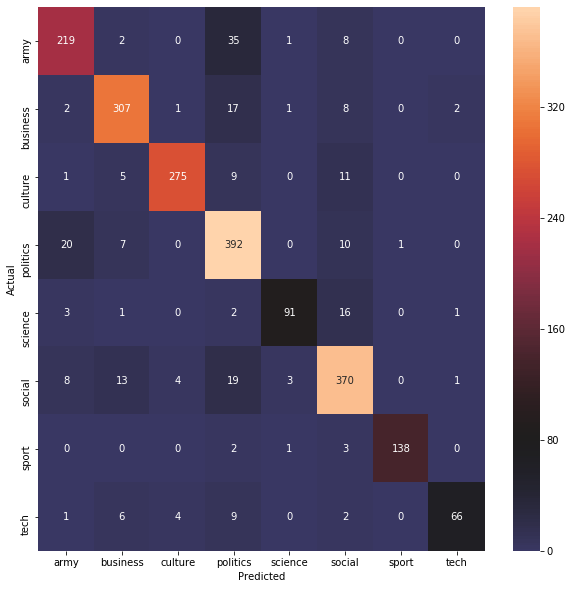

Accuracy: 0.8856053384175405
Precision: 0.9096685588543625
Recall: 0.8689618373658414
F1: 0.8866468691152072
F0.5: 0.8997390467969054
F2: 0.8754648227101043


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

catbst_w2v_pred_a = a.predict(w2v_test)
conf_mat = confusion_matrix(y_test, catbst_w2v_pred_a)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('Accuracy:', accuracy_score(y_test, catbst_w2v_pred_a))
print('Precision:', precision_score(y_test, catbst_w2v_pred_a,average='macro'))           
print('Recall:', recall_score(y_test, catbst_w2v_pred_a,average='macro'))
print('F1:', f1_score(y_test, catbst_w2v_pred_a,average='macro'))
print('F0.5:', fbeta_score(y_test, catbst_w2v_pred_a, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, catbst_w2v_pred_a, 2,average='macro'))

Выбор ресемплера

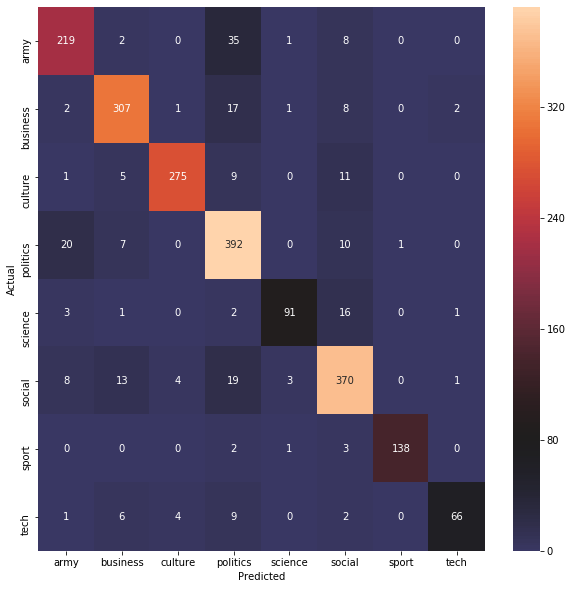

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

catbst_w2v_pred_ros = ros_cboost.predict(w2v_test)
catbst_w2v_pred_sm = sm_cboost.predict(w2v_test)
catbst_w2v_pred_ad = ad_cboost.predict(w2v_test)
catbst_w2v_pred_a = a.predict(w2v_test)
conf_mat = confusion_matrix(y_test, catbst_w2v_pred_a)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

catbst_w2v_pred_ros = SVM_ros.predict(w2v_test)
catbst_w2v_pred_sm = SVM_sm.predict(w2v_test)
catbst_w2v_pred_ad = SVM_ad.predict(w2v_test)
catbst_w2v_pred_a = SVM.predict(w2v_test)

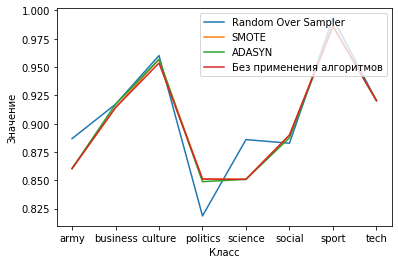

<Figure size 432x288 with 0 Axes>

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc, confusion_matrix
#pr = precision_score(y_test, catbst_w2v_pred, average='macro')
#rec = recall_score(y_test, catbst_w2v_pred, average=None)
f_ros = recall_score(y_test, catbst_w2v_pred_ros, average=None)
f_sm = recall_score(y_test, catbst_w2v_pred_sm, average=None)
f_ad = recall_score(y_test, catbst_w2v_pred_ad, average=None)
f = recall_score(y_test, catbst_w2v_pred_a, average=None)

#plt.plot(le.classes_, pr,  label='Точность')
#plt.plot(le.classes_, rec,  label='Полнота')
plt.plot(le.classes_, f_ros,  label='Random Over Sampler')
plt.plot(le.classes_, f_sm,  label='SMOTE')
plt.plot(le.classes_, f_ad,  label='ADASYN')
plt.plot(le.classes_, f,  label='Без применения алгоритмов')

plt.xlabel("Класс")
plt.ylabel("Значение")
plt.legend()
plt.show()
#plt.savefig('resampler_svm.png')

Выбор эмбеддинга

In [29]:
from imblearn.over_sampling import ADASYN

ad = ADASYN(sampling_strategy='minority')
w2v_train_resampled_ad, y_train_w2v_resampled_ad = ad.fit_resample(w2v_train, y_train)
bof_train_resampled_ad, y_train_bof_resampled_ad = ad.fit_resample(bof_train, y_train)
tfidf_train_resampled_ad, y_train_tfidf_resampled_ad = ad.fit_resample(tfidf_train, y_train)
navec_train_resampled_ad, y_train_navec_resampled_ad = ad.fit_resample(navec_train, y_train)

In [37]:
from sklearn import svm

SVM_w2v = svm.SVC(kernel='linear', gamma='auto') 
%time SVM_w2v.fit(w2v_train_resampled_ad, y_train_w2v_resampled_ad)

SVM_bow = svm.SVC(kernel='linear', gamma='auto')
%time SVM_bow.fit(bof_train_resampled_ad, y_train_bof_resampled_ad) 

SVM_tf = svm.SVC(kernel='linear', gamma='auto')
%time SVM_tf.fit(tfidf_train_resampled_ad, y_train_tfidf_resampled_ad)

SVM_nav = svm.SVC(kernel='linear', gamma='auto')
%time SVM_nav.fit(navec_train_resampled_ad, y_train_navec_resampled_ad)

CPU times: user 4.61 s, sys: 6.91 ms, total: 4.61 s
Wall time: 4.64 s
CPU times: user 55 s, sys: 0 ns, total: 55 s
Wall time: 55 s
CPU times: user 30min 21s, sys: 8min 39s, total: 39min 1s
Wall time: 4min 55s
CPU times: user 2.2 s, sys: 3.64 ms, total: 2.21 s
Wall time: 2.21 s


SVC(gamma='auto', kernel='linear')

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.39 s
CPU times: user 16.1 s, sys: 0 ns, total: 16.1 s
Wall time: 16.1 s
CPU times: user 7min 35s, sys: 2min 9s, total: 9min 44s
Wall time: 1min 13s
CPU times: user 875 ms, sys: 254 ms, total: 1.13 s
Wall time: 695 ms


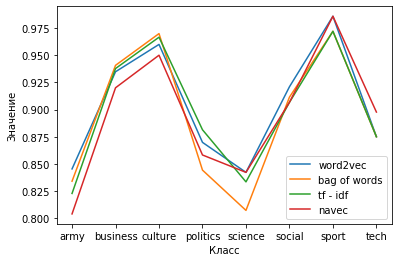

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc, confusion_matrix
%matplotlib inline

%time catbst_w2v_pred_ros = SVM_w2v.predict(w2v_test)
%time catbst_w2v_pred_sm = SVM_bow.predict(bof_test)
%time catbst_w2v_pred_ad = SVM_tf.predict(tfidf_test)
%time catbst_w2v_pred_n = SVM_nav.predict(navec_test)

#pr = precision_score(y_test, catbst_w2v_pred, average='macro')
#rec = recall_score(y_test, catbst_w2v_pred, average=None)
f_ros = recall_score(y_test, catbst_w2v_pred_ros, average=None)
f_sm = recall_score(y_test, catbst_w2v_pred_sm, average=None)
f_ad = recall_score(y_test, catbst_w2v_pred_ad, average=None)
f_n = recall_score(y_test, catbst_w2v_pred_n, average=None)

#plt.plot(le.classes_, pr,  label='Точность')
#plt.plot(le.classes_, rec,  label='Полнота')
plt.plot(le.classes_, f_ros,  label='word2vec')
plt.plot(le.classes_, f_sm,  label='bag of words')
plt.plot(le.classes_, f_ad,  label='tf - idf')
plt.plot(le.classes_, f_n,  label='navec')

plt.xlabel("Класс")
plt.ylabel("Значение")
plt.legend()
plt.show()
#plt.savefig('embedding.png')

Выбор классификатора

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from imblearn.ensemble import BalancedBaggingClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

Using TensorFlow backend.


In [40]:
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
X_train_nav = X_train.apply(str.split)
X_test_nav = X_test.apply(str.split)

def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
navec_train = X_train_nav.apply(text2vec_navec)
navec_test = X_test_nav.apply(text2vec_navec)

navec_train = np.stack(navec_train)
navec_train.shape

navec_test = np.stack(navec_test)
navec_test.shape

ad = ADASYN(sampling_strategy='minority')
navec_train_resampled_ad, y_train_navec_resampled_ad = ad.fit_resample(navec_train, y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['text_lemma'].tolist())

In [49]:
import time

SVM = svm.SVC(kernel='linear', gamma='auto')
logger('orig_svm',SVM,navec_train_resampled_ad,\
       y_train_navec_resampled_ad,navec_test,y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
logger('orig_cboost',cboost,navec_train_resampled_ad,\
       y_train_navec_resampled_ad,navec_test,y_test,\
       counter_time,counter_metrics,mode = 'cboost')
counter_time += 1
counter_metrics += 1
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
logger('orig_BalancedBagging',bbc,navec_train_resampled_ad,\
       y_train_navec_resampled_ad,navec_test,y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
logger('orig_ExtraTreesClassifier',ExTrClass,navec_train_resampled_ad,\
       y_train_navec_resampled_ad,navec_test,y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
logger('orig_RandomForestClassifier',RandFClass,navec_train_resampled_ad,\
       y_train_navec_resampled_ad,navec_test,y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
new_model = tf.keras.models.load_model('cnn_1k_new.h5')
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=1000)
logger('orig_model',new_model,[],\
       [],test_cnn_data,y_test,\
       counter_time,counter_metrics,mode = 'cnn', train_time = 1110)
counter_time += 1
counter_metrics += 1

In [12]:
SVM = svm.SVC(kernel='linear', gamma='auto')
print('Time to train svm:')
%time SVM.fit(navec_train_resampled_ad, y_train_navec_resampled_ad)
print('Time to predict using svm:')
svm_nav = SVM.predict(navec_test)
print('Accuracy:', accuracy_score(y_test, svm_nav))
print('Precision:', precision_score(y_test, svm_nav,average='macro'))           
print('Recall:', recall_score(y_test, svm_nav,average='macro'))
print('F1:', f1_score(y_test, svm_nav,average='macro'))
print('F0.5:', fbeta_score(y_test, svm_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, svm_nav, beta = 2,average='macro'))
print('-------------------------------')
sqdc = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='squared_hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=-1, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
print('Time to train sqdc:')
%time sqdc.fit(navec_train_resampled_ad, y_train_navec_resampled_ad)
print('Time to predict using sqdc:')
%time sqdc_nav = sqdc.predict(navec_test)
print('Accuracy:', accuracy_score(y_test, sqdc_nav))
print('Precision:', precision_score(y_test, sqdc_nav,average='macro'))           
print('Recall:', recall_score(y_test, sqdc_nav,average='macro'))
print('F1:', f1_score(y_test, sqdc_nav,average='macro'))
print('F0.5:', fbeta_score(y_test, sqdc_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, sqdc_nav, beta = 2,average='macro'))
print('-------------------------------')
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False
                      )
print('Time to train cboost:')
%time cboost.fit(navec_train_resampled_ad, y_train_navec_resampled_ad,eval_set=Pool(navec_test, y_test))
print('Time to predict using cboost:')
%time cboost_nav = cboost.predict(navec_test)
print('Accuracy:', accuracy_score(y_test, cboost_nav))
print('Precision:', precision_score(y_test, cboost_nav,average='macro'))           
print('Recall:', recall_score(y_test, cboost_nav,average='macro'))
print('F1:', f1_score(y_test, cboost_nav,average='macro'))
print('F0.5:', fbeta_score(y_test, cboost_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cboost_nav, beta = 2,average='macro'))
print('-------------------------------')
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
print('Time to train BalancedBagging:')
%time bbc.fit(navec_train, y_train)
print('Time to predict using BalancedBagging:')
%time bbc_nav = bbc.predict(navec_test)
print('Accuracy:', accuracy_score(y_test, bbc_nav))
print('Precision:', precision_score(y_test, bbc_nav,average='macro'))           
print('Recall:', recall_score(y_test, bbc_nav,average='macro'))
print('F1:', f1_score(y_test, bbc_nav,average='macro'))
print('F0.5:', fbeta_score(y_test, bbc_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, bbc_nav, beta = 2,average='macro'))
print('-------------------------------')
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=50, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=13, verbose=0,
                     warm_start=False)
print('Time to train ExtraTreesClassifier:')
%time ExTrClass.fit(navec_train_resampled_ad, y_train_navec_resampled_ad)
print('Time to predict using ExtraTreesClassifier:')
%time ExTrClass_nav = ExTrClass.predict(navec_test)
print('Accuracy:', accuracy_score(y_test, ExTrClass_nav))
print('Precision:', precision_score(y_test, ExTrClass_nav,average='macro'))           
print('Recall:', recall_score(y_test, ExTrClass_nav,average='macro'))
print('F1:', f1_score(y_test, ExTrClass_nav,average='macro'))
print('F0.5:', fbeta_score(y_test, ExTrClass_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, ExTrClass_nav, beta = 2,average='macro'))
print('-------------------------------')
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
print('Time to train RandomForestClassifier:')
%time RandFClass.fit(navec_train_resampled_ad, y_train_navec_resampled_ad)
print('Time to predict using RandomForestClassifier:')
%time RandFClass_nav = RandFClass.predict(navec_test)
print('Accuracy:', accuracy_score(y_test, RandFClass_nav))
print('Precision:', precision_score(y_test, RandFClass_nav,average='macro'))           
print('Recall:', recall_score(y_test, RandFClass_nav,average='macro'))
print('F1:', f1_score(y_test, RandFClass_nav,average='macro'))
print('F0.5:', fbeta_score(y_test, RandFClass_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, RandFClass_nav, beta = 2,average='macro'))
print('-------------------------------')
new_model = tf.keras.models.load_model('cnn_new.h5')
print('Time to train model: 14min')
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=800)
print('Time to predict using model:')
%time cnn_nav = new_model.predict(test_cnn_data)
cnn_nav_rev = []
for i in cnn_nav:
    cnn_nav_rev.append(np.argmax(i))
print('Accuracy:', accuracy_score(y_test, cnn_nav_rev))
print('Precision:', precision_score(y_test, cnn_nav_rev,average='macro'))           
print('Recall:', recall_score(y_test, cnn_nav_rev,average='macro'))
print('F1:', f1_score(y_test, cnn_nav_rev,average='macro'))
print('F0.5:', fbeta_score(y_test, cnn_nav_rev, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cnn_nav_rev, beta = 2,average='macro'))
print('-------------------------------')
new_model_1 = tf.keras.models.load_model('cnn_1k_new.h5')
print('Time to train model: 18.5min')
test_cnn_data = pad_sequences(test_sequences, maxlen=1000)
print('Time to predict using model with 1k word input:')
%time cnn_nav = new_model_1.predict(test_cnn_data)
cnn_nav_rev = []
for i in cnn_nav:
    cnn_nav_rev.append(np.argmax(i))
print('Accuracy:', accuracy_score(y_test, cnn_nav_rev))
print('Precision:', precision_score(y_test, cnn_nav_rev,average='macro'))           
print('Recall:', recall_score(y_test, cnn_nav_rev,average='macro'))
print('F1:', f1_score(y_test, cnn_nav_rev,average='macro'))
print('F0.5:', fbeta_score(y_test, cnn_nav_rev, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cnn_nav_rev, beta = 2,average='macro'))
print('-------------------------------')
new_model_1 = tf.keras.models.load_model('cnn_1.5k_new.h5')
print('Time to train model: 28min')
test_cnn_data = pad_sequences(test_sequences, maxlen=1500)
print('Time to predict using model with 1.5k word input:')
%time cnn_nav = new_model_1.predict(test_cnn_data)
cnn_nav_rev = []
for i in cnn_nav:
    cnn_nav_rev.append(np.argmax(i))
print('Accuracy:', accuracy_score(y_test, cnn_nav_rev))
print('Precision:', precision_score(y_test, cnn_nav_rev,average='macro'))           
print('Recall:', recall_score(y_test, cnn_nav_rev,average='macro'))
print('F1:', f1_score(y_test, cnn_nav_rev,average='macro'))
print('F0.5:', fbeta_score(y_test, cnn_nav_rev, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cnn_nav_rev, beta = 2,average='macro'))

Time to train svm:
CPU times: user 2.59 s, sys: 1.43 ms, total: 2.59 s
Wall time: 2.59 s
Time to predict using svm:
Accuracy: 0.877025738798856
Precision: 0.881433035003371
Recall: 0.8857506227011345
F1: 0.8825731249452877
F0.5: 0.8816506059338407
F2: 0.8842274816823666
-------------------------------
Time to train sqdc:
CPU times: user 1min 6s, sys: 585 µs, total: 1min 6s
Wall time: 15.3 s
Time to predict using sqdc:
CPU times: user 12.2 ms, sys: 1.32 ms, total: 13.5 ms
Wall time: 3.17 ms
Accuracy: 0.8179218303145853
Precision: 0.8242993328822751
Recall: 0.8207620775577658
F1: 0.821234200198093
F0.5: 0.822778658167234
F2: 0.8206210837976742
-------------------------------
Time to train cboost:
CPU times: user 1min 50s, sys: 48.5 s, total: 2min 39s
Wall time: 1min 44s
Time to predict using cboost:
CPU times: user 63.5 ms, sys: 9.57 ms, total: 73.1 ms
Wall time: 16.4 ms
Accuracy: 0.8693994280266921
Precision: 0.8779283254835724
Recall: 0.8666252076665963
F1: 0.8713812046728779
F0.5: 0.8

In [3]:
timings = pd.DataFrame(columns = ['name','train','predict'])
metrics = pd.DataFrame(columns = ['name','Accuracy','Precision','Recall','F1','F0.5','F2'])

counter_time = 0
counter_metrics = 0

PGN

In [4]:
from sklearn.model_selection import train_test_split
pgn_X_train, pgn_X_test, pgn_y_train, pgn_y_test = train_test_split(data['pgn_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])

In [5]:
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
pgn_X_train_nav = pgn_X_train.apply(str.split)
pgn_X_test_nav = pgn_X_test.apply(str.split)

In [6]:
%%time

def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
pgn_navec_train = pgn_X_train_nav.apply(text2vec_navec)
pgn_navec_test = pgn_X_test_nav.apply(text2vec_navec)

CPU times: user 1.55 s, sys: 16.7 ms, total: 1.57 s
Wall time: 1.57 s


In [7]:
%%time

pgn_navec_train = np.stack(pgn_navec_train)
pgn_navec_train.shape

CPU times: user 9.23 ms, sys: 4.08 ms, total: 13.3 ms
Wall time: 12.8 ms


(8390, 300)

In [8]:
pgn_navec_test = np.stack(pgn_navec_test)
pgn_navec_test.shape

(2098, 300)

In [9]:
from imblearn.over_sampling import ADASYN

ad = ADASYN(sampling_strategy='minority')
pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad = ad.fit_resample(pgn_navec_train, pgn_y_train)

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from imblearn.ensemble import BalancedBaggingClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

Using TensorFlow backend.


In [11]:
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['pgn_lemma'].tolist())

In [12]:
def logger(name,predictor,x_tr,y_tr,x_tst,y_tst,i,j,mode = 'ml',**kwargs):
    if mode == 'cnn':
        model_train = kwargs.get('train_time')
        #print('Time to train {}:'.format(name))
        tmp_time = model_train
    elif mode == 'cboost':
        #print('Time to train {}:'.format(name))
        start_time = time.time()
        predictor.fit(x_tr, y_tr,eval_set=Pool(x_tst, y_tst))
        tmp_time = time.time() - start_time
    else:
        #print('Time to train {}:'.format(name))
        start_time = time.time()
        predictor.fit(x_tr, y_tr)
        tmp_time = time.time() - start_time
    #print('Time to predict using {}:'.format(name))
    start_time = time.time()
    predictions = predictor.predict(x_tst)
    timings.loc[i] = [name,tmp_time,time.time() - start_time]
    if mode == 'cnn':
        cnn_nav_rev = []
        for i in predictions:
            cnn_nav_rev.append(np.argmax(i))
        predictions = cnn_nav_rev
    #print('Accuracy:', accuracy_score(y_tst, predictions))
    #print('Precision:', precision_score(y_tst, predictions,average='macro'))           
    #print('Recall:', recall_score(y_tst, predictions,average='macro'))
    #print('F1:', f1_score(y_tst, predictions,average='macro'))
    #print('F0.5:', fbeta_score(y_tst, predictions, beta = 0.5,average='macro'))
    #print('F2:', fbeta_score(y_tst, predictions, beta = 2,average='macro'))
    metrics.loc[j] = [name,\
                                    accuracy_score(y_tst, predictions),\
                                    precision_score(y_tst, predictions,average='macro'),\
                                    recall_score(y_tst, predictions,average='macro'),\
                                    f1_score(y_tst, predictions,average='macro'),\
                                    fbeta_score(y_tst, predictions, beta = 0.5,average='macro'),\
                                    fbeta_score(y_tst, predictions, beta = 2,average='macro')
                                   ]

In [13]:
import time

SVM = svm.SVC(kernel='linear', gamma='auto')
logger('pgn_svm',SVM,pgn_navec_train_resampled_ad,\
       pgn_y_train_navec_resampled_ad,pgn_navec_test,pgn_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
logger('pgn_cboost',cboost,pgn_navec_train_resampled_ad,\
       pgn_y_train_navec_resampled_ad,pgn_navec_test,pgn_y_test,\
       counter_time,counter_metrics,mode = 'cboost')
counter_time += 1
counter_metrics += 1
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
logger('pgn_BalancedBagging',bbc,pgn_navec_train_resampled_ad,\
       pgn_y_train_navec_resampled_ad,pgn_navec_test,pgn_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
logger('pgn_ExtraTreesClassifier',ExTrClass,pgn_navec_train_resampled_ad,\
       pgn_y_train_navec_resampled_ad,pgn_navec_test,pgn_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
logger('pgn_RandomForestClassifier',RandFClass,pgn_navec_train_resampled_ad,\
       pgn_y_train_navec_resampled_ad,pgn_navec_test,pgn_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
new_model = tf.keras.models.load_model('cnn_pgn_150_new.h5')
test_sequences = tokenizer.texts_to_sequences(pgn_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
logger('pgn_model',new_model,[],\
       [],test_cnn_data,pgn_y_test,\
       counter_time,counter_metrics,mode = 'cnn', train_time = 90)
counter_time += 1
counter_metrics += 1

In [ ]:
import time

SVM = svm.SVC(kernel='linear', gamma='auto')
print('Time to train svm:')
start_time = time.time()
%time SVM.fit(pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using svm:')
start_time = time.time()
svm_nav = SVM.predict(pgn_navec_test)
timings.loc[counter_time] = ['pgn_svm',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(pgn_y_test, svm_nav))
print('Precision:', precision_score(pgn_y_test, svm_nav,average='macro'))           
print('Recall:', recall_score(pgn_y_test, svm_nav,average='macro'))
print('F1:', f1_score(pgn_y_test, svm_nav,average='macro'))
print('F0.5:', fbeta_score(pgn_y_test, svm_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(pgn_y_test, svm_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['pgn_svm',\
                                accuracy_score(pgn_y_test, svm_nav),\
                                precision_score(pgn_y_test, svm_nav,average='macro'),\
                                recall_score(pgn_y_test, svm_nav,average='macro'),\
                                f1_score(pgn_y_test, svm_nav,average='macro'),\
                                fbeta_score(pgn_y_test, svm_nav, beta = 0.5,average='macro'),\
                                fbeta_score(pgn_y_test, svm_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
print('Time to train cboost:')
start_time = time.time()
%time cboost.fit(pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad,\
                 eval_set=Pool(pgn_navec_test, pgn_y_test))
tmp_time = time.time() - start_time
print('Time to predict using cboost:')
start_time = time.time()
%time cboost_nav = cboost.predict(pgn_navec_test)
timings.loc[counter_time] = ['pgn_cboost',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(pgn_y_test, cboost_nav))
print('Precision:', precision_score(pgn_y_test, cboost_nav,average='macro'))           
print('Recall:', recall_score(pgn_y_test, cboost_nav,average='macro'))
print('F1:', f1_score(pgn_y_test, cboost_nav,average='macro'))
print('F0.5:', fbeta_score(pgn_y_test, cboost_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(pgn_y_test, cboost_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['pgn_cboost',\
                                accuracy_score(pgn_y_test, cboost_nav),\
                                precision_score(pgn_y_test, cboost_nav,average='macro'),\
                                recall_score(pgn_y_test, cboost_nav,average='macro'),\
                                f1_score(pgn_y_test, cboost_nav,average='macro'),\
                                fbeta_score(pgn_y_test, cboost_nav, beta = 0.5,average='macro'),\
                                fbeta_score(pgn_y_test, cboost_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
print('Time to train BalancedBagging:')
start_time = time.time()
%time bbc.fit(pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using BalancedBagging:')
start_time = time.time()
%time bbc_nav = bbc.predict(pgn_navec_test)
timings.loc[counter_time] = ['pgn_BalancedBagging',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(pgn_y_test, bbc_nav))
print('Precision:', precision_score(pgn_y_test, bbc_nav,average='macro'))           
print('Recall:', recall_score(pgn_y_test, bbc_nav,average='macro'))
print('F1:', f1_score(pgn_y_test, bbc_nav,average='macro'))
print('F0.5:', fbeta_score(pgn_y_test, bbc_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(pgn_y_test, bbc_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['pgn_BalancedBagging',\
                                accuracy_score(pgn_y_test, bbc_nav),\
                                precision_score(pgn_y_test, bbc_nav,average='macro'),\
                                recall_score(pgn_y_test, bbc_nav,average='macro'),\
                                f1_score(pgn_y_test, bbc_nav,average='macro'),\
                                fbeta_score(pgn_y_test, bbc_nav, beta = 0.5,average='macro'),\
                                fbeta_score(pgn_y_test, bbc_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
print('Time to train ExtraTreesClassifier:')
start_time = time.time()
%time ExTrClass.fit(pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using ExtraTreesClassifier:')
start_time = time.time()
%time ExTrClass_nav = ExTrClass.predict(pgn_navec_test)
timings.loc[counter_time] = ['pgn_ExtraTreesClassifier',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(pgn_y_test, ExTrClass_nav))
print('Precision:', precision_score(pgn_y_test, ExTrClass_nav,average='macro'))           
print('Recall:', recall_score(pgn_y_test, ExTrClass_nav,average='macro'))
print('F1:', f1_score(pgn_y_test, ExTrClass_nav,average='macro'))
print('F0.5:', fbeta_score(pgn_y_test, ExTrClass_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(pgn_y_test, ExTrClass_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['pgn_ExtraTreesClassifier',\
                                accuracy_score(pgn_y_test, ExTrClass_nav),\
                                precision_score(pgn_y_test, ExTrClass_nav,average='macro'),\
                                recall_score(pgn_y_test, ExTrClass_nav,average='macro'),\
                                f1_score(pgn_y_test, ExTrClass_nav,average='macro'),\
                                fbeta_score(pgn_y_test, ExTrClass_nav, beta = 0.5,average='macro'),\
                                fbeta_score(pgn_y_test, ExTrClass_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
print('Time to train RandomForestClassifier:')
start_time = time.time()
%time RandFClass.fit(pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using RandomForestClassifier:')
start_time = time.time()
%time RandFClass_nav = RandFClass.predict(pgn_navec_test)
timings.loc[counter_time] = ['pgn_RandomForestClassifier',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(pgn_y_test, RandFClass_nav))
print('Precision:', precision_score(pgn_y_test, RandFClass_nav,average='macro'))           
print('Recall:', recall_score(pgn_y_test, RandFClass_nav,average='macro'))
print('F1:', f1_score(pgn_y_test, RandFClass_nav,average='macro'))
print('F0.5:', fbeta_score(pgn_y_test, RandFClass_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(pgn_y_test, RandFClass_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['pgn_RandomForestClassifier',\
                                accuracy_score(pgn_y_test, RandFClass_nav),\
                                precision_score(pgn_y_test, RandFClass_nav,average='macro'),\
                                recall_score(pgn_y_test, RandFClass_nav,average='macro'),\
                                f1_score(pgn_y_test, RandFClass_nav,average='macro'),\
                                fbeta_score(pgn_y_test, RandFClass_nav, beta = 0.5,average='macro'),\
                                fbeta_score(pgn_y_test, RandFClass_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
new_model = tf.keras.models.load_model('cnn_pgn_150_new.h5')
print('Time to train model: 1.5min')
test_sequences = tokenizer.texts_to_sequences(pgn_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
print('Time to predict using model:')
start_time = time.time()
%time cnn_nav = new_model.predict(test_cnn_data)
timings.loc[counter_time] = ['pgn_cnn',77,time.time() - start_time]
cnn_nav_rev = []
for i in cnn_nav:
    cnn_nav_rev.append(np.argmax(i))
print('Accuracy:', accuracy_score(pgn_y_test, cnn_nav_rev))
print('Precision:', precision_score(pgn_y_test, cnn_nav_rev,average='macro'))           
print('Recall:', recall_score(pgn_y_test, cnn_nav_rev,average='macro'))
print('F1:', f1_score(pgn_y_test, cnn_nav_rev,average='macro'))
print('F0.5:', fbeta_score(pgn_y_test, cnn_nav_rev, beta = 0.5,average='macro'))
print('F2:', fbeta_score(pgn_y_test, cnn_nav_rev, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['pgn_model',\
                                accuracy_score(pgn_y_test, cnn_nav_rev),\
                                precision_score(pgn_y_test, cnn_nav_rev,average='macro'),\
                                recall_score(pgn_y_test, cnn_nav_rev,average='macro'),\
                                f1_score(pgn_y_test, cnn_nav_rev,average='macro'),\
                                fbeta_score(pgn_y_test, cnn_nav_rev, beta = 0.5,average='macro'),\
                                fbeta_score(pgn_y_test, cnn_nav_rev, beta = 2,average='macro')
                               ]

LexRanc

In [14]:
from sklearn.model_selection import train_test_split
lex_X_train, lex_X_test, lex_y_train, lex_y_test = train_test_split(data['lex_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
lex_X_train_nav = lex_X_train.apply(str.split)
lex_X_test_nav = lex_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
lex_navec_train = lex_X_train_nav.apply(text2vec_navec)
lex_navec_test = lex_X_test_nav.apply(text2vec_navec)
lex_navec_train = np.stack(lex_navec_train)
lex_navec_train.shape
lex_navec_test = np.stack(lex_navec_test)
lex_navec_test.shape
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad = ad.fit_resample(lex_navec_train, lex_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['lex_lemma'].tolist())

In [15]:
import time

SVM = svm.SVC(kernel='linear', gamma='auto')
logger('lex_svm',SVM,lex_navec_train_resampled_ad,\
       lex_y_train_navec_resampled_ad,lex_navec_test,lex_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
logger('lex_cboost',cboost,lex_navec_train_resampled_ad,\
       lex_y_train_navec_resampled_ad,lex_navec_test,lex_y_test,\
       counter_time,counter_metrics,mode = 'cboost')
counter_time += 1
counter_metrics += 1
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
logger('lex_BalancedBagging',bbc,lex_navec_train_resampled_ad,\
       lex_y_train_navec_resampled_ad,lex_navec_test,lex_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
logger('lex_ExtraTreesClassifier',ExTrClass,lex_navec_train_resampled_ad,\
       lex_y_train_navec_resampled_ad,lex_navec_test,lex_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
logger('lex_RandomForestClassifier',RandFClass,lex_navec_train_resampled_ad,\
       lex_y_train_navec_resampled_ad,lex_navec_test,lex_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
new_model = tf.keras.models.load_model('cnn_lex_150.h5')
test_sequences = tokenizer.texts_to_sequences(lex_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
logger('lex_model',new_model,[],\
       [],test_cnn_data,lex_y_test,\
       counter_time,counter_metrics,mode = 'cnn', train_time = 108)
counter_time += 1
counter_metrics += 1

NN

In [16]:
from sklearn.model_selection import train_test_split
NN_X_train, NN_X_test, NN_y_train, NN_y_test = train_test_split(data['nn_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
NN_X_train_nav = NN_X_train.apply(str.split)
NN_X_test_nav = NN_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
NN_navec_train = NN_X_train_nav.apply(text2vec_navec)
NN_navec_test = NN_X_test_nav.apply(text2vec_navec)
NN_navec_train = np.stack(NN_navec_train)
NN_navec_train.shape
NN_navec_test = np.stack(NN_navec_test)
NN_navec_test.shape
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
NN_navec_train_resampled_ad, NN_y_train_navec_resampled_ad = ad.fit_resample(NN_navec_train, NN_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['nn_lemma'].tolist())

In [17]:
import time

SVM = svm.SVC(kernel='linear', gamma='auto')
logger('NN_svm',SVM,NN_navec_train_resampled_ad,\
       NN_y_train_navec_resampled_ad,NN_navec_test,NN_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
logger('NN_cboost',cboost,NN_navec_train_resampled_ad,\
       NN_y_train_navec_resampled_ad,NN_navec_test,NN_y_test,\
       counter_time,counter_metrics,mode = 'cboost')
counter_time += 1
counter_metrics += 1
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
logger('NN_BalancedBagging',bbc,NN_navec_train_resampled_ad,\
       NN_y_train_navec_resampled_ad,NN_navec_test,NN_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
logger('NN_ExtraTreesClassifier',ExTrClass,NN_navec_train_resampled_ad,\
       NN_y_train_navec_resampled_ad,NN_navec_test,NN_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
logger('NN_RandomForestClassifier',RandFClass,NN_navec_train_resampled_ad,\
       NN_y_train_navec_resampled_ad,NN_navec_test,NN_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
new_model = tf.keras.models.load_model('cnn_nn_250.h5')
test_sequences = tokenizer.texts_to_sequences(NN_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=250)
logger('NN_model',new_model,[],\
       [],test_cnn_data,NN_y_test,\
       counter_time,counter_metrics,mode = 'cnn', train_time = 90)
counter_time += 1
counter_metrics += 1

Natural

In [18]:
from sklearn.model_selection import train_test_split
nat_X_train, nat_X_test, nat_y_train, nat_y_test = train_test_split(data['summ_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
nat_X_train_nav = nat_X_train.apply(str.split)
nat_X_test_nav = nat_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
nat_navec_train = nat_X_train_nav.apply(text2vec_navec)
nat_navec_test = nat_X_test_nav.apply(text2vec_navec)
nat_navec_train = np.stack(nat_navec_train)
nat_navec_train.shape
nat_navec_test = np.stack(nat_navec_test)
nat_navec_test.shape
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
nat_navec_train_resampled_ad, nat_y_train_navec_resampled_ad = ad.fit_resample(nat_navec_train, nat_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['summ_lemma'].tolist())

In [19]:
import time

SVM = svm.SVC(kernel='linear', gamma='auto')
logger('nat_svm',SVM,nat_navec_train_resampled_ad,\
       nat_y_train_navec_resampled_ad,nat_navec_test,nat_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
logger('nat_cboost',cboost,nat_navec_train_resampled_ad,\
       nat_y_train_navec_resampled_ad,nat_navec_test,nat_y_test,\
       counter_time,counter_metrics,mode = 'cboost')
counter_time += 1
counter_metrics += 1
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
logger('nat_BalancedBagging',bbc,nat_navec_train_resampled_ad,\
       nat_y_train_navec_resampled_ad,nat_navec_test,nat_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
logger('nat_ExtraTreesClassifier',ExTrClass,nat_navec_train_resampled_ad,\
       nat_y_train_navec_resampled_ad,nat_navec_test,nat_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
logger('nat_RandomForestClassifier',RandFClass,nat_navec_train_resampled_ad,\
       nat_y_train_navec_resampled_ad,nat_navec_test,nat_y_test,\
       counter_time,counter_metrics)
counter_time += 1
counter_metrics += 1
new_model = tf.keras.models.load_model('cnn_nat_150.h5')
test_sequences = tokenizer.texts_to_sequences(nat_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
logger('nat_model',new_model,[],\
       [],test_cnn_data,nat_y_test,\
       counter_time,counter_metrics,mode = 'cnn', train_time = 105)
counter_time += 1
counter_metrics += 1

In [50]:
timings['referator'] = timings.name.apply(lambda x: x.split('_')[0])
timings['classifier'] = timings.name.apply(lambda x: x.split('_')[1])
metrics['referator'] = metrics.name.apply(lambda x: x.split('_')[0])
metrics['classifier'] = metrics.name.apply(lambda x: x.split('_')[1])

In [51]:
metrics

,name,Accuracy,Precision,Recall,F1,F0.5,F2,referator,classifier
0,pgn_svm,0.793136,0.795292,0.786066,0.788307,0.791927,0.786387,pgn,svm
1,pgn_cboost,0.774547,0.774820,0.739983,0.750130,0.762896,0.742514,pgn,cboost
2,pgn_BalancedBagging,0.651573,0.625029,0.638445,0.627874,0.625292,0.633215,pgn,BalancedBagging
3,pgn_ExtraTreesClassifier,0.765014,0.800756,0.707773,0.725920,0.757159,0.711772,pgn,ExtraTreesClassifier
4,pgn_RandomForestClassifier,0.658246,0.641371,0.606478,0.611439,0.624125,0.606794,pgn,RandomForestClassifier
5,pgn_model,0.958532,0.965334,0.951216,0.957636,0.962085,0.953646,pgn,model
6,lex_svm,0.846520,0.850573,0.852809,0.850256,0.850132,0.851409,lex,svm
7,lex_cboost,0.836034,0.851463,0.833098,0.839664,0.846071,0.835131,lex,cboost
8,lex_BalancedBagging,0.759771,0.746536,0.770621,0.755297,0.749287,0.763656,lex,BalancedBagging
9,lex_ExtraTreesClassifier,0.825548,0.851452,0.799008,0.817951,0.835808,0.805225,lex,ExtraTreesClassifier


In [52]:
timings

,name,train,predict,referator,classifier
0,pgn_svm,4.123978,1.108969,pgn,svm
1,pgn_cboost,118.824131,0.018790,pgn,cboost
2,pgn_BalancedBagging,7.688068,0.010781,pgn,BalancedBagging
3,pgn_ExtraTreesClassifier,2.315194,0.506094,pgn,ExtraTreesClassifier
4,pgn_RandomForestClassifier,0.324595,0.107116,pgn,RandomForestClassifier
5,pgn_model,90.000000,0.876038,pgn,model
6,lex_svm,2.563752,0.752390,lex,svm
7,lex_cboost,109.872966,0.013651,lex,cboost
8,lex_BalancedBagging,8.068321,0.010492,lex,BalancedBagging
9,lex_ExtraTreesClassifier,2.417022,0.202395,lex,ExtraTreesClassifier


In [53]:
with pd.ExcelWriter('metrics.xlsx') as writer:
    metrics.to_excel(writer,'sheet1')

In [54]:
with pd.ExcelWriter('timings.xlsx') as writer:
    timings.to_excel(writer,'sheet1')

In [47]:
metrics = metrics[:-6]
timings = timings[:-6]

In [48]:
metrics = metrics.drop(['referator','classifier'],axis = 1)
timings = timings.drop(['referator','classifier'],axis = 1)

## Исследование ошибок

In [8]:
from imblearn.over_sampling import ADASYN

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec

path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
X_train_nav = X_train.apply(str.split)
X_test_nav = X_test.apply(str.split)

def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
navec_train = X_train_nav.apply(text2vec_navec)
navec_test = X_test_nav.apply(text2vec_navec)

navec_train = np.stack(navec_train)
navec_train.shape

navec_test = np.stack(navec_test)
navec_test.shape

ad = ADASYN(sampling_strategy='minority')
navec_train_resampled_ad, y_train_navec_resampled_ad = ad.fit_resample(navec_train, y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['text_lemma'].tolist())

In [9]:
new_model = tf.keras.models.load_model('cnn_1k_new.h5')
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=1000)

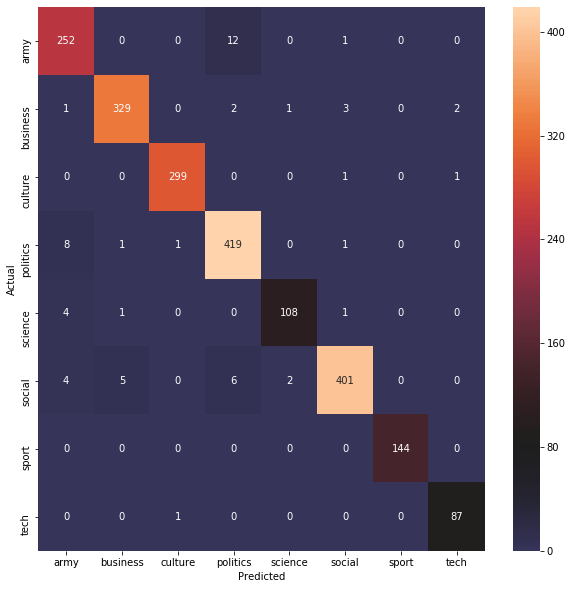

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

predictions = new_model.predict(test_cnn_data)
cnn_nav_rev = []
for i in predictions:
    cnn_nav_rev.append(np.argmax(i))
predictions = cnn_nav_rev
conf_mat = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
nat_X_train, nat_X_test, nat_y_train, nat_y_test = train_test_split(data['summ_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
nat_X_train_nav = nat_X_train.apply(str.split)
nat_X_test_nav = nat_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
nat_navec_train = nat_X_train_nav.apply(text2vec_navec)
nat_navec_test = nat_X_test_nav.apply(text2vec_navec)
nat_navec_train = np.stack(nat_navec_train)
nat_navec_test = np.stack(nat_navec_test)
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
nat_navec_train_resampled_ad, nat_y_train_navec_resampled_ad = ad.fit_resample(nat_navec_train, nat_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['summ_lemma'].tolist())

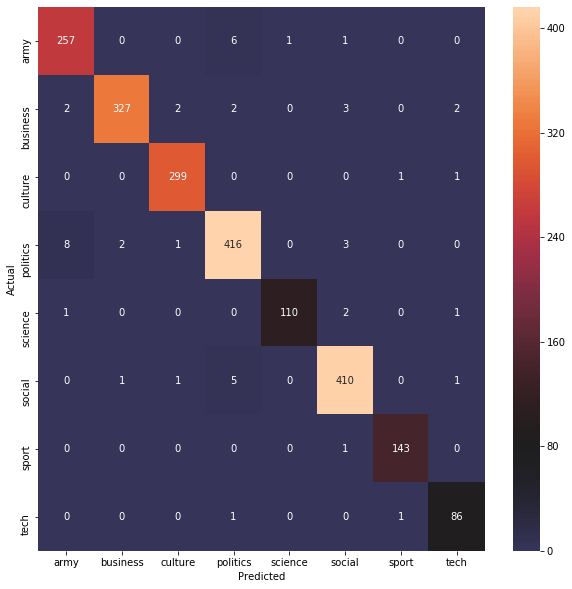

In [8]:
new_model = tf.keras.models.load_model('cnn_nat_150.h5')
test_sequences = tokenizer.texts_to_sequences(nat_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

predictions = new_model.predict(test_cnn_data)
cnn_nav_rev = []
for i in predictions:
    cnn_nav_rev.append(np.argmax(i))
predictions = cnn_nav_rev
conf_mat = confusion_matrix(nat_y_test, predictions)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
NN_X_train, NN_X_test, NN_y_train, NN_y_test = train_test_split(data['nn_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
NN_X_train_nav = NN_X_train.apply(str.split)
NN_X_test_nav = NN_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
NN_navec_train = NN_X_train_nav.apply(text2vec_navec)
NN_navec_test = NN_X_test_nav.apply(text2vec_navec)
NN_navec_train = np.stack(NN_navec_train)
NN_navec_train.shape
NN_navec_test = np.stack(NN_navec_test)
NN_navec_test.shape
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
NN_navec_train_resampled_ad, NN_y_train_navec_resampled_ad = ad.fit_resample(NN_navec_train, NN_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['nn_lemma'].tolist())

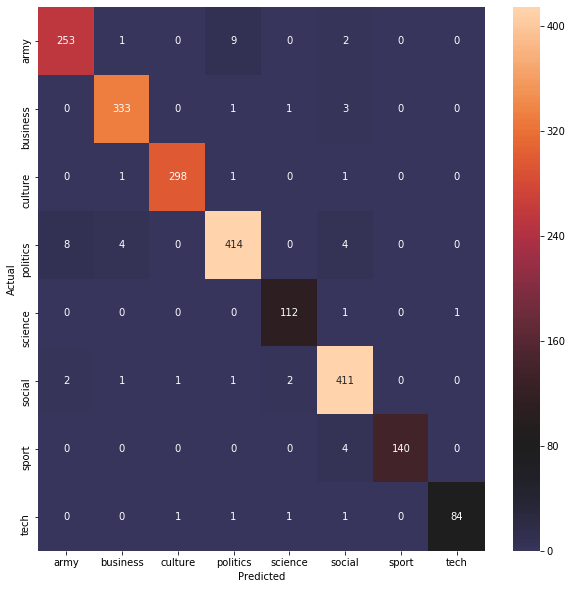

In [12]:
new_model = tf.keras.models.load_model('cnn_nn_250.h5')
test_sequences = tokenizer.texts_to_sequences(NN_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=250)
import matplotlib.pyplot as plt
import seaborn as sns
predictions = new_model.predict(test_cnn_data)
cnn_nav_rev = []
for i in predictions:
    cnn_nav_rev.append(np.argmax(i))
predictions = cnn_nav_rev
conf_mat = confusion_matrix(NN_y_test, predictions)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
pgn_X_train, pgn_X_test, pgn_y_train, pgn_y_test = train_test_split(data['pgn_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
pgn_X_train_nav = pgn_X_train.apply(str.split)
pgn_X_test_nav = pgn_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
pgn_navec_train = pgn_X_train_nav.apply(text2vec_navec)
pgn_navec_test = pgn_X_test_nav.apply(text2vec_navec)
pgn_navec_train = np.stack(pgn_navec_train)
pgn_navec_test = np.stack(pgn_navec_test)
ad = ADASYN(sampling_strategy='minority')
pgn_navec_train_resampled_ad, pgn_y_train_navec_resampled_ad = ad.fit_resample(pgn_navec_train, pgn_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['pgn_lemma'].tolist())

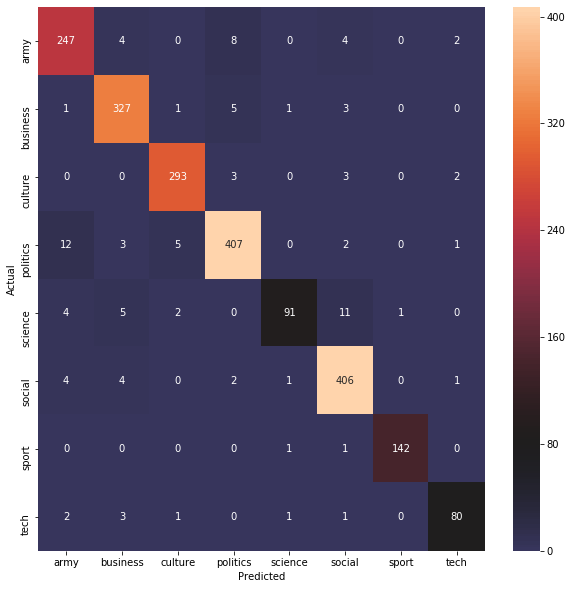

In [15]:
new_model = tf.keras.models.load_model('cnn_pgn_150_new.h5')
test_sequences = tokenizer.texts_to_sequences(pgn_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
import matplotlib.pyplot as plt
import seaborn as sns
predictions = new_model.predict(test_cnn_data)
cnn_nav_rev = []
for i in predictions:
    cnn_nav_rev.append(np.argmax(i))
predictions = cnn_nav_rev
conf_mat = confusion_matrix(pgn_y_test, predictions)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
lex_X_train, lex_X_test, lex_y_train, lex_y_test = train_test_split(data['lex_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
lex_X_train_nav = lex_X_train.apply(str.split)
lex_X_test_nav = lex_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
lex_navec_train = lex_X_train_nav.apply(text2vec_navec)
lex_navec_test = lex_X_test_nav.apply(text2vec_navec)
lex_navec_train = np.stack(lex_navec_train)
lex_navec_train.shape
lex_navec_test = np.stack(lex_navec_test)
lex_navec_test.shape
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad = ad.fit_resample(lex_navec_train, lex_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['lex_lemma'].tolist())

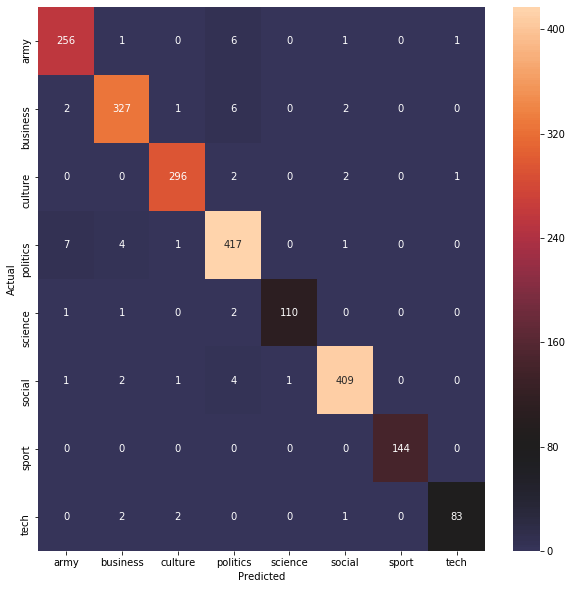

In [17]:
new_model = tf.keras.models.load_model('cnn_lex_150.h5')
test_sequences = tokenizer.texts_to_sequences(lex_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
import matplotlib.pyplot as plt
import seaborn as sns
predictions = new_model.predict(test_cnn_data)
cnn_nav_rev = []
for i in predictions:
    cnn_nav_rev.append(np.argmax(i))
predictions = cnn_nav_rev
conf_mat = confusion_matrix(lex_y_test, predictions)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
lex_X_train, lex_X_test, lex_y_train, lex_y_test = train_test_split(data['lex_lemma'], data['clas'], test_size=0.2, stratify=data['clas'])
from navec import Navec
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)
lex_X_train_nav = lex_X_train.apply(str.split)
lex_X_test_nav = lex_X_test.apply(str.split)
def text2vec_navec(text):
    """Усредняем векторы слов"""
    vecs = []
    for word in text:
        try:
            vecs.append(navec[word])
        except KeyError:
            pass
    return np.sum(vecs, axis=0) / len(vecs)
lex_navec_train = lex_X_train_nav.apply(text2vec_navec)
lex_navec_test = lex_X_test_nav.apply(text2vec_navec)
lex_navec_train = np.stack(lex_navec_train)
lex_navec_train.shape
lex_navec_test = np.stack(lex_navec_test)
lex_navec_test.shape
from imblearn.over_sampling import ADASYN
ad = ADASYN(sampling_strategy='minority')
lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad = ad.fit_resample(lex_navec_train, lex_y_train)
VOCAB_SIZE = 8000000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['lex_lemma'].tolist())
import time
SVM = svm.SVC(kernel='linear', gamma='auto')
print('Time to train svm:')
start_time = time.time()
%time SVM.fit(lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using svm:')
start_time = time.time()
svm_nav = SVM.predict(lex_navec_test)
timings.loc[counter_time] = ['lex_svm',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(lex_y_test, svm_nav))
print('Precision:', precision_score(lex_y_test, svm_nav,average='macro'))           
print('Recall:', recall_score(lex_y_test, svm_nav,average='macro'))
print('F1:', f1_score(lex_y_test, svm_nav,average='macro'))
print('F0.5:', fbeta_score(lex_y_test, svm_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(lex_y_test, svm_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['lex_svm',\
                                accuracy_score(lex_y_test, svm_nav),\
                                precision_score(lex_y_test, svm_nav,average='macro'),\
                                recall_score(lex_y_test, svm_nav,average='macro'),\
                                f1_score(lex_y_test, svm_nav,average='macro'),\
                                fbeta_score(lex_y_test, svm_nav, beta = 0.5,average='macro'),\
                                fbeta_score(lex_y_test, svm_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
cboost = CatBoostClassifier(n_estimators=800,
                       max_depth=10, 
                       task_type="GPU",
                       eval_metric='MultiClass',
                       use_best_model=True,
                       classes_count = len(le.classes_),
                       od_type = 'IncToDec',
                       verbose = False)
print('Time to train cboost:')
start_time = time.time()
%time cboost.fit(lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad,\
                 eval_set=Pool(lex_navec_test, lex_y_test))
tmp_time = time.time() - start_time
print('Time to predict using cboost:')
start_time = time.time()
%time cboost_nav = cboost.predict(lex_navec_test)
timings.loc[counter_time] = ['lex_cboost',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(lex_y_test, cboost_nav))
print('Precision:', precision_score(lex_y_test, cboost_nav,average='macro'))           
print('Recall:', recall_score(lex_y_test, cboost_nav,average='macro'))
print('F1:', f1_score(lex_y_test, cboost_nav,average='macro'))
print('F0.5:', fbeta_score(lex_y_test, cboost_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(lex_y_test, cboost_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['lex_cboost',\
                                accuracy_score(lex_y_test, cboost_nav),\
                                precision_score(lex_y_test, cboost_nav,average='macro'),\
                                recall_score(lex_y_test, cboost_nav,average='macro'),\
                                f1_score(lex_y_test, cboost_nav,average='macro'),\
                                fbeta_score(lex_y_test, cboost_nav, beta = 0.5,average='macro'),\
                                fbeta_score(lex_y_test, cboost_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
print('Time to train BalancedBagging:')
start_time = time.time()
%time bbc.fit(lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using BalancedBagging:')
start_time = time.time()
%time bbc_nav = bbc.predict(lex_navec_test)
timings.loc[counter_time] = ['lex_BalancedBagging',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(lex_y_test, bbc_nav))
print('Precision:', precision_score(lex_y_test, bbc_nav,average='macro'))           
print('Recall:', recall_score(lex_y_test, bbc_nav,average='macro'))
print('F1:', f1_score(lex_y_test, bbc_nav,average='macro'))
print('F0.5:', fbeta_score(lex_y_test, bbc_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(lex_y_test, bbc_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['lex_BalancedBagging',\
                                accuracy_score(lex_y_test, bbc_nav),\
                                precision_score(lex_y_test, bbc_nav,average='macro'),\
                                recall_score(lex_y_test, bbc_nav,average='macro'),\
                                f1_score(lex_y_test, bbc_nav,average='macro'),\
                                fbeta_score(lex_y_test, bbc_nav, beta = 0.5,average='macro'),\
                                fbeta_score(lex_y_test, bbc_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
ExTrClass = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                                 max_depth=50, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators=500,
                                 n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                                 warm_start=False
                                )
print('Time to train ExtraTreesClassifier:')
start_time = time.time()
%time ExTrClass.fit(lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using ExtraTreesClassifier:')
start_time = time.time()
%time ExTrClass_nav = ExTrClass.predict(lex_navec_test)
timings.loc[counter_time] = ['lex_ExtraTreesClassifier',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(lex_y_test, ExTrClass_nav))
print('Precision:', precision_score(lex_y_test, ExTrClass_nav,average='macro'))           
print('Recall:', recall_score(lex_y_test, ExTrClass_nav,average='macro'))
print('F1:', f1_score(lex_y_test, ExTrClass_nav,average='macro'))
print('F0.5:', fbeta_score(lex_y_test, ExTrClass_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(lex_y_test, ExTrClass_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['lex_ExtraTreesClassifier',\
                                accuracy_score(lex_y_test, ExTrClass_nav),\
                                precision_score(lex_y_test, ExTrClass_nav,average='macro'),\
                                recall_score(lex_y_test, ExTrClass_nav,average='macro'),\
                                f1_score(lex_y_test, ExTrClass_nav,average='macro'),\
                                fbeta_score(lex_y_test, ExTrClass_nav, beta = 0.5,average='macro'),\
                                fbeta_score(lex_y_test, ExTrClass_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
RandFClass = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                    max_depth=50, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_estimators=10,
                                    n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                                    warm_start=False)
print('Time to train RandomForestClassifier:')
start_time = time.time()
%time RandFClass.fit(lex_navec_train_resampled_ad, lex_y_train_navec_resampled_ad)
tmp_time = time.time() - start_time
print('Time to predict using RandomForestClassifier:')
start_time = time.time()
%time RandFClass_nav = RandFClass.predict(lex_navec_test)
timings.loc[counter_time] = ['lex_RandomForestClassifier',tmp_time,time.time() - start_time]
print('Accuracy:', accuracy_score(lex_y_test, RandFClass_nav))
print('Precision:', precision_score(lex_y_test, RandFClass_nav,average='macro'))           
print('Recall:', recall_score(lex_y_test, RandFClass_nav,average='macro'))
print('F1:', f1_score(lex_y_test, RandFClass_nav,average='macro'))
print('F0.5:', fbeta_score(lex_y_test, RandFClass_nav, beta = 0.5,average='macro'))
print('F2:', fbeta_score(lex_y_test, RandFClass_nav, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['lex_RandomForestClassifier',\
                                accuracy_score(lex_y_test, RandFClass_nav),\
                                precision_score(lex_y_test, RandFClass_nav,average='macro'),\
                                recall_score(lex_y_test, RandFClass_nav,average='macro'),\
                                f1_score(lex_y_test, RandFClass_nav,average='macro'),\
                                fbeta_score(lex_y_test, RandFClass_nav, beta = 0.5,average='macro'),\
                                fbeta_score(lex_y_test, RandFClass_nav, beta = 2,average='macro')
                               ]
counter_time += 1
counter_metrics += 1
print('-------------------------------')
new_model = tf.keras.models.load_model('cnn_lex_150.h5')
print('Time to train model: 1.5min')
test_sequences = tokenizer.texts_to_sequences(lex_X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=150)
print('Time to predict using model:')
start_time = time.time()
%time cnn_nav = new_model.predict(test_cnn_data)
timings.loc[counter_time] = ['lex_cnn',90,time.time() - start_time]
cnn_nav_rev = []
for i in cnn_nav:
    cnn_nav_rev.append(np.argmax(i))
print('Accuracy:', accuracy_score(lex_y_test, cnn_nav_rev))
print('Precision:', precision_score(lex_y_test, cnn_nav_rev,average='macro'))           
print('Recall:', recall_score(lex_y_test, cnn_nav_rev,average='macro'))
print('F1:', f1_score(lex_y_test, cnn_nav_rev,average='macro'))
print('F0.5:', fbeta_score(lex_y_test, cnn_nav_rev, beta = 0.5,average='macro'))
print('F2:', fbeta_score(lex_y_test, cnn_nav_rev, beta = 2,average='macro'))
metrics.loc[counter_metrics] = ['lex_model',\
                                accuracy_score(lex_y_test, cnn_nav_rev),\
                                precision_score(lex_y_test, cnn_nav_rev,average='macro'),\
                                recall_score(lex_y_test, cnn_nav_rev,average='macro'),\
                                f1_score(lex_y_test, cnn_nav_rev,average='macro'),\
                                fbeta_score(lex_y_test, cnn_nav_rev, beta = 0.5,average='macro'),\
                                fbeta_score(lex_y_test, cnn_nav_rev, beta = 2,average='macro')
                               ]

Time to train svm:
CPU times: user 2.95 s, sys: 0 ns, total: 2.95 s
Wall time: 2.95 s
Time to predict using svm:
Accuracy: 0.834604385128694
Precision: 0.8404992835478597
Recall: 0.8439473593694111
F1: 0.841172496347093
F0.5: 0.8405360668276483
F2: 0.8425631387512462
-------------------------------
Time to train cboost:
CPU times: user 1min 56s, sys: 50.3 s, total: 2min 47s
Wall time: 1min 51s
Time to predict using cboost:
CPU times: user 71.3 ms, sys: 0 ns, total: 71.3 ms
Wall time: 17.9 ms
Accuracy: 0.8088655862726406
Precision: 0.8230397118766577
Recall: 0.8022635170234049
F1: 0.8102692438020973
F0.5: 0.8173385217699827
F2: 0.8049104892961485
-------------------------------
Time to train BalancedBagging:
CPU times: user 8.95 s, sys: 0 ns, total: 8.95 s
Wall time: 8.09 s
Time to predict using BalancedBagging:
CPU times: user 9.95 ms, sys: 0 ns, total: 9.95 ms
Wall time: 9.72 ms
Accuracy: 0.7321258341277407
Precision: 0.7205141956462642
Recall: 0.7435288163560256
F1: 0.728939349314836

OSError: SavedModel file does not exist at: cnn_lex_150.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

catbst_w2v_pred_a = a.predict(w2v_test)
conf_mat = confusion_matrix(y_test, catbst_w2v_pred_a)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print('Accuracy:', accuracy_score(y_test, catbst_w2v_pred_a))
print('Precision:', precision_score(y_test, catbst_w2v_pred_a,average='macro'))           
print('Recall:', recall_score(y_test, catbst_w2v_pred_a,average='macro'))
print('F1:', f1_score(y_test, catbst_w2v_pred_a,average='macro'))
print('F0.5:', fbeta_score(y_test, catbst_w2v_pred_a, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, catbst_w2v_pred_a, 2,average='macro'))

In [18]:
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
SVM_w2v = svm.SVC(kernel='linear', gamma='auto')
SVM_w2v.fit(w2v_train, y_train)

SVC(gamma='auto', kernel='linear')

In [34]:
print('Accuracy:', accuracy_score(y_test, catbst_w2v_pred_a))
print('Precision:', precision_score(y_test, catbst_w2v_pred_a,average='macro'))           
print('Recall:', recall_score(y_test, catbst_w2v_pred_a,average='macro'))
print('F1:', f1_score(y_test, catbst_w2v_pred_a,average='macro'))
print('F0.5:', fbeta_score(y_test, catbst_w2v_pred_a, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, catbst_w2v_pred_a, 2,average='macro'))

Accuracy: 0.8661764705882353
Precision: 0.8745425498734873
Recall: 0.861354085569014
F1: 0.8673559429185607
F0.5: 0.8715230928097166
F2: 0.8636149423583257


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [21]:
print('Accuracy:', accuracy_score(y_test, catbst_w2v_pred))
print('Precision:', precision_score(y_test, catbst_w2v_pred,average='macro'))           
print('Recall:', recall_score(y_test, catbst_w2v_pred,average='macro'))
print('F1:', f1_score(y_test, catbst_w2v_pred,average='macro'))
print('F0.5:', fbeta_score(y_test, catbst_w2v_pred, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, catbst_w2v_pred, 2,average='macro'))

Accuracy: 0.8641563393708294
Precision: 0.8763836335891516
Recall: 0.857001412726401
F1: 0.865448940872205
F0.5: 0.871688043373902
F2: 0.8601026926920585


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


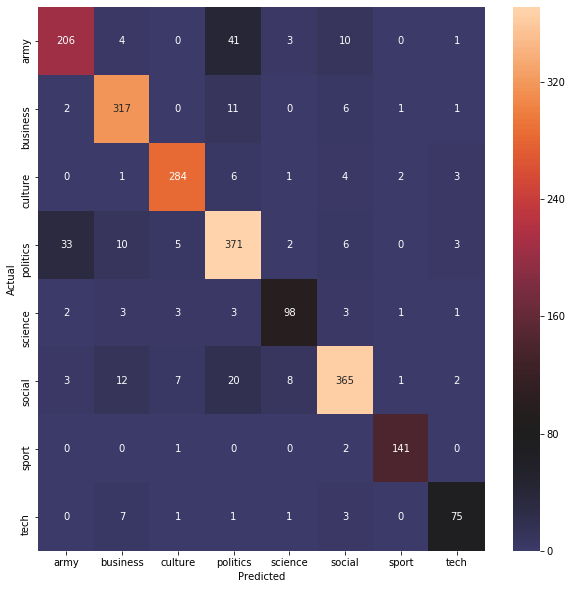

Accuracy: 0.8851286939942803
Precision: 0.8894093493272788
Recall: 0.8857293579729069
F1: 0.8872147039201326
F0.5: 0.8884449774681026
F2: 0.8862396357761386


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [19]:
import matplotlib.pyplot as plt

svm_w2v_pred = SVM_w2v.predict(w2v_test)
conf_mat = confusion_matrix(y_test, svm_w2v_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Accuracy:', accuracy_score(y_test, svm_w2v_pred))
print('Precision:', precision_score(y_test, svm_w2v_pred,average='macro'))           
print('Recall:', recall_score(y_test, svm_w2v_pred,average='macro'))
print('F1:', f1_score(y_test, svm_w2v_pred,average='macro'))
print('F0.5:', fbeta_score(y_test, svm_w2v_pred, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, svm_w2v_pred, 2,average='macro'))

In [23]:
svm_w2v_pred

array([3, 1, 5, ..., 5, 4, 4])

In [43]:
ExTrClass_w2v = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=50, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=13, verbose=0,
                     warm_start=False)
ExTrClass_w2v.fit(w2v_train_resampled_ros, y_resampled_ros)

ExtraTreesClassifier(max_depth=50, n_estimators=500, random_state=13)

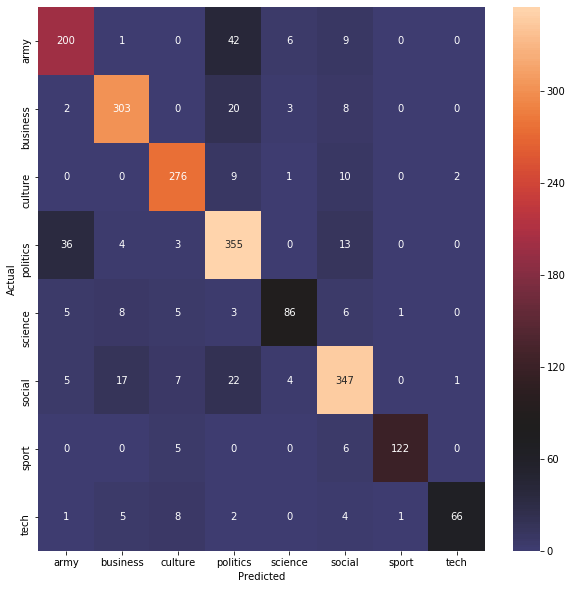

Accuracy: 0.8602941176470589
Precision: 0.8815820802557608
Recall: 0.8447803799112601
F1: 0.8608897372741784
F0.5: 0.8726781968669892
F2: 0.8507411492315928


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [44]:
ExTrClass_w2v_pred = ExTrClass_w2v.predict(w2v_test)
conf_mat = confusion_matrix(y_test, ExTrClass_w2v_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Accuracy:', accuracy_score(y_test, ExTrClass_w2v_pred))
print('Precision:', precision_score(y_test, ExTrClass_w2v_pred,average='macro'))           
print('Recall:', recall_score(y_test, ExTrClass_w2v_pred,average='macro'))
print('F1:', f1_score(y_test, ExTrClass_w2v_pred,average='macro'))
print('F0.5:', fbeta_score(y_test, ExTrClass_w2v_pred, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, ExTrClass_w2v_pred, 2,average='macro'))

In [46]:
RandFClass_w2v = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
RandFClass_w2v.fit(w2v_train_resampled_ros, y_resampled_ros)

RandomForestClassifier(max_depth=50, n_estimators=10, random_state=0)

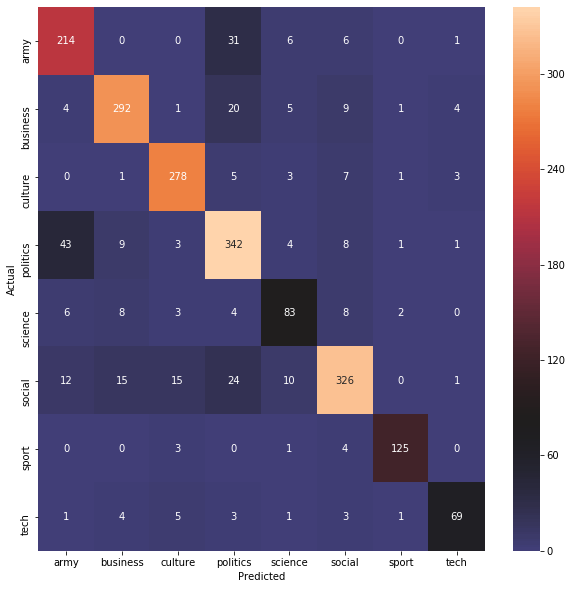

Accuracy: 0.8475490196078431
Precision: 0.8490574470756895
Recall: 0.8416829910007675
F1: 0.8446827222294702
F0.5: 0.8471380690512353
F2: 0.8427218288473554


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [47]:
RandFClass_w2v_pred = RandFClass_w2v.predict(w2v_test)
conf_mat = confusion_matrix(y_test, RandFClass_w2v_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Accuracy:', accuracy_score(y_test, RandFClass_w2v_pred))
print('Precision:', precision_score(y_test, RandFClass_w2v_pred,average='macro'))           
print('Recall:', recall_score(y_test, RandFClass_w2v_pred,average='macro'))
print('F1:', f1_score(y_test, RandFClass_w2v_pred,average='macro'))
print('F0.5:', fbeta_score(y_test, RandFClass_w2v_pred, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, RandFClass_w2v_pred, 2,average='macro'))

In [49]:
from sklearn import linear_model

sgd_w2v = linear_model.SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
sgd_w2v.fit(w2v_train_resampled_ros, y_resampled_ros)

SGDClassifier()

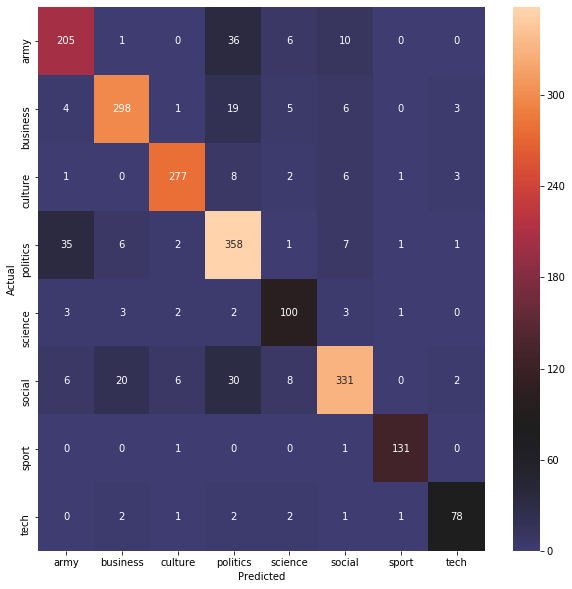

Accuracy: 0.8715686274509804
Precision: 0.8790406925362302
Recall: 0.8827627372937096
F1: 0.8801402274421579
F0.5: 0.879300414042083
F2: 0.8815275409982596


/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=0.5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/disco/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass beta=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [50]:
sgd_w2v_pred = sgd_w2v.predict(w2v_test)
conf_mat = confusion_matrix(y_test, sgd_w2v_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Accuracy:', accuracy_score(y_test, sgd_w2v_pred))
print('Precision:', precision_score(y_test, sgd_w2v_pred,average='macro'))           
print('Recall:', recall_score(y_test, sgd_w2v_pred,average='macro'))
print('F1:', f1_score(y_test, sgd_w2v_pred,average='macro'))
print('F0.5:', fbeta_score(y_test, sgd_w2v_pred, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, sgd_w2v_pred, 2,average='macro'))

набросок обучения

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import gensim
from sklearn.decomposition import FactorAnalysis
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

In [12]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1500
VOCAB_SIZE = 8000000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['text_lemma'].tolist())
training_sequences = tokenizer.texts_to_sequences(X_train.tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word2vec = navec
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

Found 73906 unique tokens.
(73907, 300)


In [13]:
test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels_train = to_categorical(np.asarray(y_train), num_classes=len(le.classes_), dtype='float64')
labels_test = to_categorical(np.asarray(y_test), num_classes=len(le.classes_), dtype='float64')

In [14]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs,axis=1)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()])
    model.summary()
    return model

In [23]:
del model

In [15]:
from tensorflow import keras
import tensorflow as tf



model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH,
                len(train_word_index)+1, EMBEDDING_DIM, len(list(le.classes_)), False)

early_stopping = EarlyStopping(monitor='val_recall', min_delta=0.02, patience=4, verbose=1,mode = 'max')
callbacks_list = [early_stopping]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1500, 300)    22172100    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1498, 128)    115328      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1497, 128)    153728      embedding[0][0]                  
______________________________________________________________________________________________

In [16]:
hist = model.fit(train_cnn_data, labels_train,
                 callbacks=callbacks_list, 
                 validation_data=(test_cnn_data, labels_test),
                 epochs=25, 
                 batch_size=256)

Epoch 1/25
33/33 [==============================] - 111s 3s/step - loss: 1.3137 - categorical_accuracy: 0.1951 - precision: 0.1834 - recall: 0.1797 - val_loss: 0.3415 - val_categorical_accuracy: 0.4438 - val_precision: 1.0000 - val_recall: 0.0038
Epoch 2/25
33/33 [==============================] - 110s 3s/step - loss: 0.3698 - categorical_accuracy: 0.3829 - precision: 0.4391 - recall: 0.2020 - val_loss: 0.2318 - val_categorical_accuracy: 0.6449 - val_precision: 0.8824 - val_recall: 0.4218
Epoch 3/25
33/33 [==============================] - 110s 3s/step - loss: 0.2775 - categorical_accuracy: 0.5699 - precision: 0.6161 - recall: 0.4318 - val_loss: 0.1657 - val_categorical_accuracy: 0.7498 - val_precision: 0.8775 - val_recall: 0.5872
Epoch 4/25
33/33 [==============================] - 110s 3s/step - loss: 0.2083 - categorical_accuracy: 0.6926 - precision: 0.7151 - recall: 0.5942 - val_loss: 0.1271 - val_categorical_accuracy: 0.8041 - val_precision: 0.9052 - val_recall: 0.6921
Epoch 5/25
3

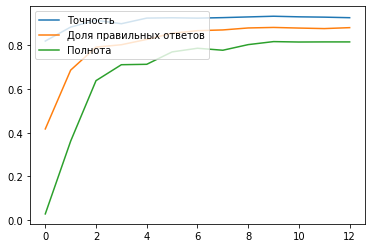

In [33]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_precision'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.plot(hist.history['val_recall'])
plt.legend(['Точность','Доля правильных ответов','Полнота'], loc='upper left')
plt.show()

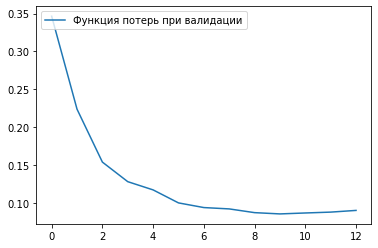

In [34]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_loss'])
plt.legend(['Функция потерь при валидации'], loc='upper left')
plt.show()

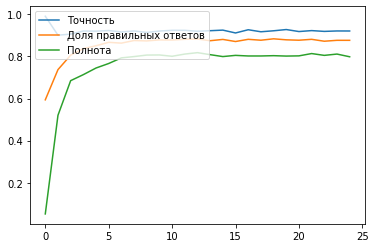

In [60]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_precision_4'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.plot(hist.history['val_recall_4'])
plt.legend(['Точность','Доля правильных ответов','Полнота'], loc='upper left')
plt.show()

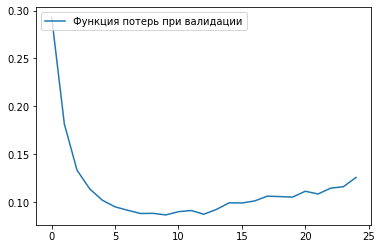

In [61]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_loss'])
plt.legend(['Функция потерь при валидации'], loc='upper left')
plt.show()

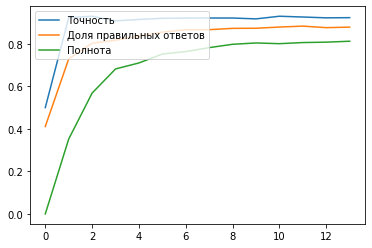

In [82]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_precision_12'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.plot(hist.history['val_recall_12'])
plt.legend(['Точность','Доля правильных ответов','Полнота'], loc='upper left')
plt.show()

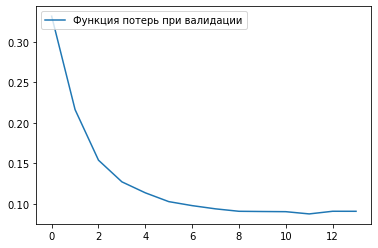

In [84]:
from matplotlib import pyplot as plt
plt.plot(hist.history['val_loss'])
plt.legend(['Функция потерь при валидации'], loc='upper left')
plt.show()

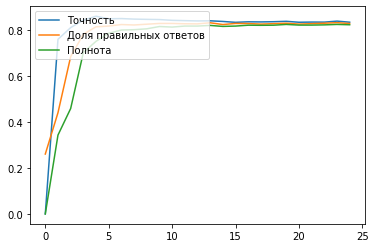

In [73]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_precision_3'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['val_recall_3'])
plt.legend(['Точность','Доля правильных ответов','Полнота'], loc='upper left')
plt.show()
#plt.savefig('test_fin.png')

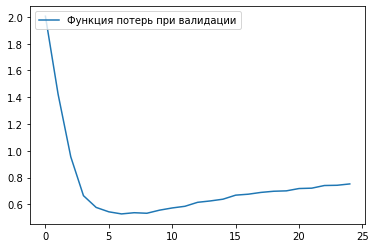

In [74]:
from matplotlib import pyplot as plt
plt.plot(history.history['val_loss'])
plt.legend(['Функция потерь при валидации'], loc='upper left')
plt.show()

/home/disco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


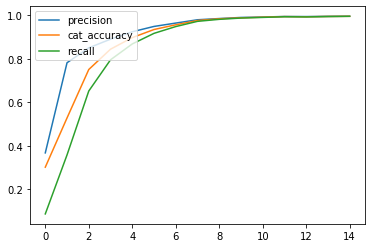

In [69]:
from matplotlib import pyplot as plt
plt.plot(history.history['precision_4'])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['recall_4'])
plt.legend(['precision','cat_accuracy','recall'], loc='upper left')
plt.show()
plt.savefig('train_fin.png')

In [18]:
model_w2v_pred = model.predict(test_cnn_data)
print(model_w2v_pred)

[[2.6913285e-03 4.1084588e-03 3.7072368e-05 ... 2.2938848e-04
  4.0366634e-05 8.7535693e-05]
 [2.1037191e-02 2.0131469e-04 1.3995811e-01 ... 2.6503205e-04
  6.9510963e-05 2.9549003e-04]
 [2.2370845e-02 2.6860833e-04 1.6039610e-04 ... 2.2498071e-03
  1.7032027e-04 5.3700845e-05]
 ...
 [3.5727584e-12 1.1204551e-08 3.0657415e-10 ... 1.3488375e-09
  9.9915123e-01 1.2487077e-18]
 [1.2700933e-01 6.7390007e-05 1.9776644e-05 ... 3.6311041e-05
  9.6112839e-05 1.0398918e-06]
 [1.5375018e-04 2.1308661e-04 1.4453530e-03 ... 6.0666907e-01
  6.2416155e-05 3.7146547e-05]]


In [20]:
np.argmax(model_w2v_pred[7])

3

In [50]:
(model_w2v_pred[0])

array([4.0823221e-04, 5.2392781e-03, 1.0992110e-02, 3.9538741e-04,
       3.9002299e-03, 7.5220507e-01, 1.0970235e-03, 2.1409094e-03],
      dtype=float32)

In [52]:
(model_w2v_pred[4])

array([0.00374386, 0.50681263, 0.00189468, 0.04456946, 0.02755901,
       0.04950339, 0.00196022, 0.01028889], dtype=float32)

In [12]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [97]:
!pip install -q pyyaml h5py

In [17]:
model.save('cnn_1.5k_new.h5')

In [13]:
new_model = tf.keras.models.load_model('cnn.h5')

In [14]:
new_model.summary()


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 800, 300)     20241600    input_17[0][0]                   
__________________________________________________________________________________________________
conv1d_60 (Conv1D)              (None, 798, 128)     115328      embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 797, 128)     153728      embedding_16[0][0]               
___________________________________________________________________________________________

In [101]:
conf_mat = confusion_matrix(y_test, model_w2v_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, center = 81)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Accuracy:', accuracy_score(y_test, sgd_w2v_pred))
print('Precision:', precision_score(y_test, sgd_w2v_pred,average='macro'))           
print('Recall:', recall_score(y_test, sgd_w2v_pred,average='macro'))
print('F1:', f1_score(y_test, sgd_w2v_pred,average='macro'))
print('F0.5:', fbeta_score(y_test, sgd_w2v_pred, 0.5,average='macro'))
print('F2:', fbeta_score(y_test, sgd_w2v_pred, 2,average='macro'))

NameError: name 'confusion_matrix' is not defined

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import gensim
from sklearn.decomposition import FactorAnalysis
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

In [47]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 250
VOCAB_SIZE = 80000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(data['lex_lemma'].tolist())
training_sequences = tokenizer.texts_to_sequences(X_train.tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

word2vec = navec
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

test_sequences = tokenizer.texts_to_sequences(X_test.tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels_train = to_categorical(np.asarray(y_train), num_classes=len(le.classes_), dtype='float64')
labels_test = to_categorical(np.asarray(y_test), num_classes=len(le.classes_), dtype='float64')

Found 41858 unique tokens.
(41859, 300)


In [48]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs,axis=1)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()])
    model.summary()
    return model

In [46]:
del model

In [49]:
from tensorflow import keras
import tensorflow as tf



model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH,
                len(train_word_index)+1, EMBEDDING_DIM, len(list(le.classes_)), False)

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.02, patience=4, verbose=1,mode = 'max')
callbacks_list = [early_stopping]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 300)     12557700    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 248, 128)     115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 247, 128)     153728      embedding_1[0][0]                
____________________________________________________________________________________________

In [50]:
hist = model.fit(train_cnn_data, labels_train,
                 callbacks=callbacks_list, 
                 validation_data=(test_cnn_data, labels_test),
                 epochs=25, 
                 batch_size=256)

Epoch 1/25
33/33 [==============================] - 20s 578ms/step - loss: 1.1313 - categorical_accuracy: 0.2059 - precision_1: 0.1670 - recall_1: 0.1409 - val_loss: 0.3245 - val_categorical_accuracy: 0.5300 - val_precision_1: 0.7961 - val_recall_1: 0.1173
Epoch 2/25
33/33 [==============================] - 18s 554ms/step - loss: 0.2718 - categorical_accuracy: 0.6338 - precision_1: 0.8165 - recall_1: 0.2482 - val_loss: 0.1763 - val_categorical_accuracy: 0.7483 - val_precision_1: 0.8347 - val_recall_1: 0.5991
Epoch 3/25
33/33 [==============================] - 18s 552ms/step - loss: 0.1545 - categorical_accuracy: 0.7701 - precision_1: 0.8494 - recall_1: 0.6583 - val_loss: 0.1346 - val_categorical_accuracy: 0.7817 - val_precision_1: 0.8536 - val_recall_1: 0.6978
Epoch 4/25
33/33 [==============================] - 18s 551ms/step - loss: 0.1132 - categorical_accuracy: 0.8268 - precision_1: 0.8850 - recall_1: 0.7488 - val_loss: 0.1191 - val_categorical_accuracy: 0.8141 - val_precision_1: 0.

In [51]:
model_w2v_pred = model.predict(test_cnn_data)
print(model_w2v_pred)

[[4.9606594e-01 2.2940338e-03 1.9349456e-03 ... 2.4893582e-02
  9.3170333e-05 5.4147792e-01]
 [9.9985039e-01 4.8130032e-06 5.2183609e-06 ... 2.2470891e-02
  5.9688574e-07 2.2374093e-06]
 [9.1299450e-01 9.2198261e-06 2.0512938e-04 ... 3.0338764e-04
  9.9880326e-06 4.4310468e-06]
 ...
 [2.9449078e-05 3.2596886e-03 2.4005473e-03 ... 7.9447329e-01
  2.5519729e-04 2.9948801e-02]
 [2.2793895e-06 3.4286976e-03 9.7202533e-01 ... 6.1181188e-04
  2.0974874e-04 2.1114945e-03]
 [2.9402077e-03 3.8432920e-01 3.6354701e-05 ... 1.6451389e-02
  1.3310741e-05 3.9070845e-04]]


In [52]:
cnn_nav_test = []
for i in model_w2v_pred:
    cnn_nav_test.append(np.argmax(i))
print('Accuracy:', accuracy_score(y_test, cnn_nav_test))
print('Precision:', precision_score(y_test, cnn_nav_test,average='macro'))           
print('Recall:', recall_score(y_test, cnn_nav_test,average='macro'))
print('F1:', f1_score(y_test, cnn_nav_test,average='macro'))
print('F0.5:', fbeta_score(y_test, cnn_nav_test, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cnn_nav_test, beta = 2,average='macro'))

Accuracy: 0.8436606291706387
Precision: 0.8559204773057254
Recall: 0.8345112946883558
F1: 0.8437997087821254
F0.5: 0.850698469633778
F2: 0.8379174094938413


In [44]:
cnn_nav_test = []
for i in model_w2v_pred:
    cnn_nav_test.append(np.argmax(i))
print('Accuracy:', accuracy_score(y_test, cnn_nav_test))
print('Precision:', precision_score(y_test, cnn_nav_test,average='macro'))           
print('Recall:', recall_score(y_test, cnn_nav_test,average='macro'))
print('F1:', f1_score(y_test, cnn_nav_test,average='macro'))
print('F0.5:', fbeta_score(y_test, cnn_nav_test, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cnn_nav_test, beta = 2,average='macro'))

Accuracy: 0.8174451858913251
Precision: 0.8321182917484815
Recall: 0.8042923776728057
F1: 0.816372701033788
F0.5: 0.8253537319350972
F2: 0.8087081369487205


In [17]:
old_model = tf.keras.models.load_model('cnn_pgn_150.h5')

In [18]:
model_w2v_pred = old_model.predict(test_cnn_data)

In [19]:
cnn_nav_test = []
for i in model_w2v_pred:
    cnn_nav_test.append(np.argmax(i))
print('Accuracy:', accuracy_score(y_test, cnn_nav_test))
print('Precision:', precision_score(y_test, cnn_nav_test,average='macro'))           
print('Recall:', recall_score(y_test, cnn_nav_test,average='macro'))
print('F1:', f1_score(y_test, cnn_nav_test,average='macro'))
print('F0.5:', fbeta_score(y_test, cnn_nav_test, beta = 0.5,average='macro'))
print('F2:', fbeta_score(y_test, cnn_nav_test, beta = 2,average='macro'))

ValueError: Found input variables with inconsistent numbers of samples: [2098, 1259]

In [45]:
model.save('cnn_lex_150.h5') 110

In [54]:
model.save('cnn_lex_250.h5') 180